# **Customising Gymnasium Environments and Implementing Reinforcement Learning Agents with Stable-Baselines3**

*Trabalho por*: Inês Castro (202304060), Soraia Costa (202305078), Simão Gomes (202304752)


Coisas a incluir:<br>
“Since episode length is fixed, a per-step time penalty would act mostly as a constant offset and may introduce unnecessary negative bias. Therefore, we prioritize event-based shaping using only action information, applying penalties only to clearly degenerate patterns (e.g., prolonged NOOP or action repetition), which preserves the dominance of terminal scoring rewards.” - removido penalidade por tempo <br>
Falar sobre como usamos penalizações pequenas e esparsas para não introduzir penalization fatigue (o agente vê que tudo o que faz está mal então não faz nada) e troca de penalizações por falta de movimento em incentivo por movimento<br>

2.3 : descobrir como fazer citações em condições :O <br>
Tá aqui só para não ficar perdido lá no meio <br>

<br>
As métricas extraídas, comparadas e analisadas serão as seguintes:
- TEMPO MÉDIO GOLO MARCADO - avalia a capacidade ofensiva dos agentes
- TEMPO MÉDIO GOLO SOFRIDO - avalia a capacidade defensiva dos agentes
- DIFERENÇA DE GOLOS MÉDIA (<0, adversário ganha; >0, agentes ganham) - comparação com os agentes adversários
- TEMPO POSSE DO DISCO - se tiver pouco, não está a tocar no disco; se tiver muito não está a rematar, será avaliado em conjunto com o tempo adversário
- TEMPO ADVERSÁRIO POSSE DO DISCO

model = PPO('MlpPolicy', env, verbose=1, device='cuda', tensorboard_log=logdir) #site com gráfico em tempo real

***
# **índice**

### 1. Introduction
   - 1.1. Objective
   - 1.2. Environment Selection: IceHockey-v5
   - 1.3. Motivation and Expected Outcomes

### 2. Environment Analysis
   - 2.1. Original Environment Overview
        - Observation Space
        - Action Space
        - Reward Structure
        - Game Mechanics
   - 2.2. Baseline Performance Analysis
        - Random Agent Behavior
   - 2.3. Identified Modification Opportunities

### 3. Environment Customization
   - 3.1. Reward Engineering Design
        - Proposed Modifications
        - Theoretical Justification
   - 3.2. Implementation
        - Custom Wrapper Code
        - Testing and Validation
   - 3.3. Modified Environment Behavior
        - Expected vs Actual Changes
        - Edge Cases Handling

### 4. Baseline Agent
   - 4.1. Algorithm Selection
        - Why DQN/PPO?
        - Alternative Considerations
   - 4.2. Baseline Configuration
        - Hyperparameters (Default)
        - Training Setup
   - 4.3. Baseline Training
        - Training Process
        - Convergence Analysis
   - 4.4. Baseline Results
        - Performance Metrics
        - Behavior Analysis

### 5. Custom Environment Agent
   - 5.1. Training with Custom Rewards
        - Same Algorithm, New Environment
        - Training Process
   - 5.2. Hyperparameter Tuning
        - Configurations Tested
        - Tuning Methodology
        - Rationale for Each Change
   - 5.3. Results per Configuration
        - Configuration 1: [name]
        - Configuration 2: [name]
        - Configuration 3: [name]
   - 5.4. Best Model Selection

### 6. Evaluation and Comparison
   - 6.1. Evaluation Methodology
        - Metrics Definition
        - Evaluation Protocol
   - 6.2. Quantitative Results
        - Performance Comparison Table
        - Statistical Significance Tests
   - 6.3. Qualitative Analysis
        - Behavioral Differences
        - Play Style Comparison
   - 6.4. Learning Curves Analysis
        - Training Progression
        - Convergence Comparison
   - 6.5. Visualizations
        - Reward Evolution
        - Action Distributions
        - Game Statistics

### 7. Discussion
   - 7.1. What Worked
        - Successful Modifications
        - Positive Impacts
   - 7.2. What Didn't Work
        - Failed Approaches
        - Unexpected Behaviors
   - 7.3. Insights and Learnings
        - Reward Shaping Implications
        - Trade-offs Discovered
   - 7.4. Limitations
        - Technical Constraints
        - Time/Resource Limitations

### 8. Conclusions
   - 8.1. Summary of Findings
   - 8.2. Impact of Customizations
   - 8.3. Future Work

### 9. References


***
## **1. Introduction**

### 1.1 Objective
[inserir objetivo]

### 1.2 Environment Selection: IceHockey-v5
[Explicar o porquê de escolhermos IceHockey]
- Two-player ice hockey game
- Discrete action space (18 actions)
- Sparse reward structure
- Strategic gameplay requirements

### 1.3 Motivation and Expected Outcomes
[O que esperamos alcançar]

***
## **2. Environment Analysis**
[Informação do ambiente](https://ale.farama.org/environments/ice_hockey/)<br>


Neste ambiente controlamos uma equipa de 2 jogadores, para simular como era jogado o IceHockey nós só controlamos um dos jogadores de cada vez.<br>
O jogador da equipa a ser controlado muda automaticamente conforme a proximidade do disco.

### 2.1 Original Environment Overview

In [1]:
import gymnasium as gym
import ale_py
import numpy as np

# Create environment
env = gym.make("ALE/IceHockey-v5", render_mode="rgb_array")

print("=== Environment Information ===")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")
print(f"Action Meanings: {env.unwrapped.get_action_meanings()}")

env.close()

=== Environment Information ===
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Action Space: Discrete(18)
Action Meanings: ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT', 'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


A recompensa inicial deste ambiente é +1 por ponto marcado, -1 por ponto sofrido.<br>
Um score negativo indica vitória do adversário e um positivo indica vitória da nossa equipa. 

### 2.2 Baseline Performance Analysis

In [2]:
def test_random_agent(env, n_episodes=50):
    """Test random policy - basic stats"""
    episode_rewards = []
    episode_lengths = []
    
    for ep in range(n_episodes):
        obs, info = env.reset()
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            steps += 1
            done = terminated or truncated
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
    
    print(f"Random Agent Performance:")
    print(f"  Mean Reward: {np.mean(episode_rewards):.2f} ± {np.std(episode_rewards):.2f}")
    print(f"  Mean Length: {np.mean(episode_lengths):.1f}")
    
    return episode_rewards, episode_lengths

env = gym.make('ALE/IceHockey-v5')
random_rewards, random_lengths = test_random_agent(env)
env.close()

Random Agent Performance:
  Mean Reward: -9.90 ± 3.71
  Mean Length: 3322.5


### 2.3 Identified Modification Opportunities

The current reward function used in the Ice Hockey environment is a purely sparse objective reward, providing:

- +1 for scoring a goal

- –1 for conceding a goal

While this formulation captures the final objective of the game, it presents several limitations that directly hinder the learning performance of reinforcement learning agents, particularly in multi-agent and continuous-time domains. Based on insights from recent studies in MARL applied to robot football and simulated sports environments, several modification opportunities can be identified.


1. **Sparse Rewards Are Ineffective in Long-Horizon, Multi-Agent Tasks**

Sparse scoring events provide too little information for the agent to learn meaningful behaviours.  
Multiple studies highlight the limitations of using goals as the only training signal.

- *“Goals are infrequent events that provide little learning signal for credit assignment.”*  
  — *Embedding Contextual Information Through Reward Shaping* :contentReference[oaicite:0]{index=0}

- *“The reward associated with scoring has low impact due to its rarity.”*  
  — *The Role of a Reward in Shaping Multiple Football Agents’ Behavior* :contentReference[oaicite:1]{index=1}

***Opportunity:*** 
Introduce dense shaping rewards to provide feedback at every timestep, improving sample efficiency and stabilizing learning.


2. **Lack of Intermediate Feedback Prevents Effective Credit Assignment**

With only ±1 at terminal states, agents cannot distinguish which specific actions contributed to success or failure.

- rSoccer results demonstrate that sparse rewards cause agents to *“fail to learn coordinated behaviours”* and that rewards become *“inadequate when observation dimensionality increases”* :contentReference[oaicite:2]{index=2}.

- The GRF benchmark shows that adding checkpoint rewards dramatically improves learning stability:  
  *“Dense reward shows better and more stable performance than sparse reward.”* :contentReference[oaicite:3]{index=3}

***Opportunity:*** 
Add intermediate tactical rewards (e.g., puck recovery, successful passes, shots on target).


3. **No Directional Guidance Leads to Unstructured or Random Policies**

The current reward provides no gradient for progress toward the opponent’s goal, leading to exploratory behaviours that do not contribute to scoring.

In GRF, directional shaping (CHECKPOINT reward) was introduced for exactly this reason:

- *“CHECKPOINTS reward substantially reduces exploratory actions by guiding the player toward the opponent’s goal.”*  
  — GRF MARL Benchmark :contentReference[oaicite:4]{index=4}

***Opportunity:***  
Include a **progress reward** based on puck displacement toward the opponent’s goal.


4. **Lack of Coordination Incentives Produces Degenerate Multi-Agent Behavior**

Sparse rewards do not encourage:

- spacing  
- defensive support  
- coordinated pressure  
- role differentiation  

This problem is documented in rSoccer, where:

- *“Agents block each other and fail to collaborate when no shaping is provided.”*  
  — rSoccer Framework :contentReference[oaicite:5]{index=5}

***Opportunity:***  
Add shaping terms encouraging cooperative behaviour such as spacing, puck recovery, and avoidance of collisions.


5. **Sparse Rewards Lead to Overfitting and Non-Generalizable Strategies**

Agents trained solely on goal rewards may learn brittle strategies that exploit specific opponent weaknesses rather than robust tactical principles.

The GRF benchmark warns that:

- *“Training solely against fixed opponents leads to overfitting; policies remain far from robust.”*  
  — GRF Full-Game Analysis :contentReference[oaicite:6]{index=6}

***Opportunity:***  
Reward behaviours that generalize across opponents (e.g., maintaining possession, structured defensive pressure).

***
## 3. Environment Customization

### 3.1 Reward Engineering Design

**Initial Proposed Modifications:**<br>
reward inicial = 0

1. ***Golos (igual):***
if scored_goal: reward += 1.0
if conceded_goal: reward -= 1.0

2. ***Direção (inspirado no CHECKPOINT):***
reward += k1 * (old_dist_to_goal - new_dist_to_goal)

3. ***Posse do puck:***
if has_puck: reward += 0.01
else: reward -= 0.01

4. ***Pressão e defesa:***
reward += k2 * (old_dist_t o_puck - new_dist_to_puck)

5. ***Ações úteis:***
if completed_pass: reward += 0.1
if shot_on_goal: reward += 0.05
if steal_puck: reward += 0.2

6. ***Penalizações:***
if agent_idle_too_long: reward -= 0.02
if teammates_too_close: reward -= 0.02

**Implementation Reality:**
Due to Atari environment constraints (pixel-based observations without 
direct access to game state), we adapted the reward engineering to use
available information.

**Implemented Modifications:**
1. ***Golos (igual):***<br>
if scored_goal: reward += 1.0
if conceded_goal: reward -= 1.0

2. ***[Removido] Penalização por tempo:***<br>
reward -= 0.002

3. ***Incentivo (leve) ao movimento:***<br>
if action in {'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT'}: reward += 0.001

4. ***Incentivo (leve) ao fire:***<br>
if action in {'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE'}: reward += 0.002


5. ***Penalização por repetição excessiva da mesma ação (N vezes):***<br>
if same_action_repeated >= N: reward += -0.001 * (same_action_repeated - N + 1) 

6. ***Penalização por janela sem tentativas de remate nos últimos W passos:***<br>
if last_W_steps contain 0 FIRE actions: reward += -0.01


[mudar isto em baixo]
#### *Reward Shaping Under Limited Observability*

The Ice Hockey environment considered in this work provides a highly restricted interface for reward design.  
At each timestep, the learning agent only observes the chosen **discrete action** and the **terminal outcome** of the episode (goal scored: +1, goal conceded: −1). No intermediate state information is available, such as puck position, player positions, possession status, or spatial relationships between agents.

This limitation fundamentally constrains the type of reward engineering that can be applied.



**Why State-Based Reward Shaping Is Not Applicable**

Recent works on multi-agent reinforcement learning in football-based environments rely heavily on **state-dependent reward shaping**:

- Expected Possession Value (EPV) and Pitch Control in Google Research Football  
- Directional progress rewards (CHECKPOINT)  
- Positional and role-based shaping  
- Possession-based dense rewards  

These techniques require access to spatial and contextual information, such as ball location, agent positions, or control of space.  
Without such information, it is **not possible to compute** progress toward goal, possession value, or tactical positioning.

As highlighted by Zhang et al., contextual reward shaping derives its effectiveness from embedding *state information* into the reward signal, which is not available in this environment.



**Consequences of Using a Purely Sparse Reward**

Using only terminal rewards (+1/−1) leads to several well-documented issues:

- Extremely sparse learning signal due to rare scoring events  
- Poor credit assignment across long action sequences  
- High variance between training runs  
- Emergence of degenerate behaviours such as looping, idling, or action spamming  

These problems are consistently reported across football-based MARL benchmarks, including rSoccer and Google Research Football.

Therefore, even under limited observability, introducing **some form of dense shaping** is necessary to stabilize training.



**Action-Based Reward Shaping as the Maximum Feasible Alternative**

Given the absence of state information, the only viable alternative is to base reward shaping **solely on the agent’s discrete action choices and their temporal patterns**.

This approach does not attempt to approximate tactical correctness directly.  
Instead, it aims to:

- Reduce unproductive exploration  
- Prevent degenerate policies  
- Encourage action diversity  
- Improve sample efficiency during early training  

Specifically, the adopted shaping includes:

- A small per-step time penalty to discourage excessively long episodes  
- Penalization of NOOP and repeated identical actions to prevent idling and loops  
- Light incentives for movement and movement-plus-fire actions to encourage active play  
- Sliding-window constraints to avoid policies that never shoot or only shoot  

This mirrors the intent of dense shaping in state-rich environments, but at a **behavioral level rather than a spatial level**.



**Relationship to Prior Work**

While simpler than state-based shaping methods, action-based reward shaping aligns with key conclusions from the literature:

- Dense rewards are essential for learning stability in sparse-outcome environments  
- Shaping should reduce exploration of obviously suboptimal behaviours  
- Preventing degenerate policies is as important as rewarding successful outcomes  

The Google Research Football benchmark demonstrates that even minimal dense shaping (e.g., CHECKPOINT rewards) dramatically improves learning stability.  
In the present setting, action-based shaping serves the same functional role under stricter information constraints.



**Scope and Limitations**

It is important to emphasize that this shaping strategy:

- Does **not** encode tactical knowledge  
- Does **not** guarantee that rewarded actions are objectively correct  
- Is intentionally kept small in magnitude to preserve the dominance of the terminal goal reward  

Its purpose is not to replace state-based reward engineering, but to **mitigate the limitations of sparse rewards when no state information is available**.



**Conclusion**

Under full observability, state-dependent reward shaping would be preferred.  
However, given the constraints of the Ice Hockey environment, action-based reward shaping represents the **maximum feasible and principled reward engineering approach**. It improves learning stability and sample efficiency while remaining consistent with the limited information available to the agent.


### 3.2 Implementation

In [35]:
from logging import info
from gymnasium import Wrapper
from collections import deque

class CustomRewardWrapper(Wrapper):
    """
    Custom IceHockey environment with engineered rewards.
    
    Reward Components:
    1. Goals: +1.0 scored, -1.0 conceded
    2. [REMOVIDO] Time penalty: -0.002 per step
    3. Movement incentive: +0.001 for directional actions
    4. Fire incentive: +0.002 for fire actions
    5. Repetition penalty: -0.001 * (repeats - N + 1) for excessive repetition
    6. Fire window penalty: -0.01 if no FIRE in last W steps
    """
    
    def __init__(self, 
                 env,
                 goal_scored_reward=1.0,
                 goal_conceded_penalty=-1.0,
                 movement_bonus=0.001,
                 fire_bonus=0.002,
                 repetition_penalty_base=-0.001,
                 repetition_threshold=5,  # N 
                 fire_window_penalty=-0.01,
                 fire_window_size=30):    # W
        super().__init__(env)
        
        # Reward parameters
        self.goal_scored_reward = goal_scored_reward
        self.goal_conceded_penalty = goal_conceded_penalty
        self.movement_bonus = movement_bonus
        self.fire_bonus = fire_bonus
        self.repetition_penalty_base = repetition_penalty_base
        self.repetition_threshold = repetition_threshold
        self.fire_window_penalty = fire_window_penalty
        self.fire_window_size = fire_window_size
        
        # Get action meanings from environment
        self.action_meanings = [
                'NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN',
                'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT',
                'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE',
                'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE'
            ]
        
        # Actions
        self.movement_actions = {'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT'}
        self.fire_actions = {'UPFIRE', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 
                            'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE'}
        
        # Tracking
        self.action_history = deque(maxlen=100)  # For repetition detection
        self.fire_history = deque(maxlen=fire_window_size)  # For fire window
        self.repetition_counter = 0
        self.last_action = None
        
        # Statistics
        self.stats = self._init_stats()
    
    
    def _init_stats(self):
        """Initialize statistics dictionary"""
        return {
            'goals_scored': 0,
            'goals_conceded': 0,
            'total_original_reward': 0.0,
            'total_modified_reward': 0.0,
            'movement_bonuses': 0,
            'fire_bonuses': 0,
            'repetition_penalties': 0,
            'fire_window_penalties': 0,
            'total_steps': 0,
        }
    
    def reset(self, **kwargs):
        """Reset environment and tracking variables"""
        self.action_history.clear()
        self.fire_history.clear()
        self.repetition_counter = 0
        self.last_action = None
        self.stats = self._init_stats()
        
        return self.env.reset(**kwargs)
    
    def step(self, action):
        """Execute action and apply reward engineering"""
        obs, reward, terminated, truncated, info = self.env.step(action)
        
        # Store original reward
        original_reward = reward
        modified_reward = reward
        self.stats['total_steps'] += 1
        
        # Track action
        self.action_history.append(action)

        action_name = self.action_meanings[action] 
        is_move_action = action_name in self.movement_actions
        is_fire_action = action_name in self.fire_actions or action_name == "FIRE"

        self.fire_history.append(1 if is_fire_action else 0)
        

        # 1. GOALS (Original rewards)
        if reward > 0:  # Goal scored
            modified_reward = self.goal_scored_reward
            self.stats['goals_scored'] += 1
            
        elif reward < 0:  # Goal conceded
            modified_reward = self.goal_conceded_penalty
            self.stats['goals_conceded'] += 1
        
        """
        # 2. TIME PENALTY (Every step)
        modified_reward += self.time_penalty
        self.stats['time_penalties'] += 1
        """

        # 3. MOVEMENT INCENTIVE
        if is_move_action:
            modified_reward += self.movement_bonus
            self.stats['movement_bonuses'] += 1


        # 4. FIRE INCENTIVE
        if is_fire_action:
            modified_reward += self.fire_bonus
            self.stats['fire_bonuses'] += 1


        # 5. REPETITION PENALTY
        # Count consecutive same actions
        if action == self.last_action:
            self.repetition_counter += 1
        else:
            self.repetition_counter = 1
            self.last_action = action
        
        # Apply penalty if exceeds threshold
        if self.repetition_counter >= self.repetition_threshold:
            # Formula: -0.001 * (same_action_repeated - N + 1)
            penalty_multiplier = (self.repetition_counter - 
                                self.repetition_threshold + 1)
            repetition_penalty = self.repetition_penalty_base * penalty_multiplier
            modified_reward += repetition_penalty
            self.stats['repetition_penalties'] += 1
    

        # 6. FIRE WINDOW PENALTY
        # Check if fire history is full and has no fires
        if len(self.fire_history) >= self.fire_window_size:
            fire_count_in_window = sum(self.fire_history)
            
            if fire_count_in_window == 0:
                modified_reward += self.fire_window_penalty
                self.stats['fire_window_penalties'] += 1
        
        
        # TRACKING
        self.stats['total_original_reward'] += original_reward
        self.stats['total_modified_reward'] += modified_reward
        
        
        # Add detailed info
        info['original_reward'] = original_reward
        info['modified_reward'] = modified_reward
        info['reward_components'] = {
            'base_reward': reward,
            'movement_bonus': self.movement_bonus if is_move_action else 0,
            'fire_bonus': self.fire_bonus if is_fire_action else 0,
            'repetition_penalty': (self.repetition_penalty_base * 
                                  (self.repetition_counter - self.repetition_threshold + 1)
                                  if self.repetition_counter >= self.repetition_threshold else 0),
            'fire_window_penalty': (self.fire_window_penalty 
                                   if len(self.fire_history) >= self.fire_window_size 
                                   and sum(self.fire_history) == 0 else 0),
        }
        info['episode_stats'] = self.stats.copy()
        info['action_name'] = action_name
        info['repetition_count'] = self.repetition_counter
        info['fires_in_window'] = sum(self.fire_history) if self.fire_history else 0
        
        return obs, modified_reward, terminated, truncated, info


### 3.3 Testing Custom Environment

In [4]:
from stable_baselines3.common.atari_wrappers import AtariWrapper

def make_custom_icehockey_env():
    env = gym.make('ALE/IceHockey-v5')
    env = AtariWrapper(env)
    env = CustomRewardWrapper(env)
    return env

In [6]:
env = make_custom_icehockey_env()
random_rewards, random_lengths = test_random_agent(env)
env.close()

Random Agent Performance:
  Mean Reward: -20.92 ± 2.87
  Mean Length: 835.0


***
## 4. Baseline Agent

### 4.1 Algorithms to be used
To establish robust baselines, we trained three different RL algorithms:

1. **DQN (Deep Q-Network)**
   - **Type**: Value-based
   - **Strengths**: Proven performance on Atari, off-policy learning
   - **Best for**: Discrete action spaces with image observations
   - **Reference**: Mnih et al. (2015)

2. **PPO (Proximal Policy Optimization)**
   - **Type**: Policy gradient
   - **Strengths**: Stable, good sample efficiency, widely used
   - **Best for**: Both discrete and continuous actions
   - **Reference**: Schulman et al. (2017)

3. **A2C (Advantage Actor-Critic)**
   - **Type**: Actor-Critic
   - **Strengths**: Fast training, synchronous updates
   - **Best for**: Faster baseline, good exploration
   - **Reference**: Mnih et al. (2016)

These algorithms represent different RL "families" and provide diverse
perspectives on the baseline performance.

### 4.2 Baseline Configuration

In [7]:
from stable_baselines3 import DQN, PPO, A2C
import os


class Config:
    """Training configuration"""
    
    # Environment
    ENV_ID = 'ALE/IceHockey-v5'
    N_STACK = 4
    
    # Training
    TOTAL_TIMESTEPS = 1_000_000  # 1 MILLION per algorithm
    EVAL_FREQ = 10_000
    N_EVAL_EPISODES = 20
    SAVE_FREQ = 50_000
    DEVICE = 'cuda'
    
    # Directories
    BASE_DIR = 'baseline_1M/'
    MODELS_DIR = BASE_DIR + 'models/'
    LOGS_DIR = BASE_DIR + 'logs/'
    RESULTS_DIR = BASE_DIR + 'results/'
    FIGURES_DIR = BASE_DIR + 'figures/'
    
    # Algorithms with optimized hyperparameters for Atari
    ALGORITHMS = {
        'DQN': {
            'class': DQN,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 1e-4,
                'buffer_size': 100_000,
                'learning_starts': 50_000,  # Start learning after more exploration
                'batch_size': 32,
                'tau': 1.0,
                'gamma': 0.99,
                'train_freq': 4,
                'gradient_steps': 1,
                'target_update_interval': 10_000,
                'exploration_fraction': 0.1,
                'exploration_initial_eps': 1.0,
                'exploration_final_eps': 0.01,  # More exploration
                'verbose': 1,
            }
        },
        'PPO': {
            'class': PPO,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 2.5e-4,
                'n_steps': 128,
                'batch_size': 256,
                'n_epochs': 4,
                'gamma': 0.99,
                'gae_lambda': 0.95,
                'clip_range': 0.1,
                'clip_range_vf': None,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5,
                'verbose': 1,
            }
        },
        'A2C': {
            'class': A2C,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 7e-4,
                'n_steps': 5,
                'gamma': 0.99,
                'gae_lambda': 1.0,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5,
                'rms_prop_eps': 1e-5,
                'verbose': 1,
            }
        }
    }

    @classmethod 
    def create_dirs(cls):
            """Create all necessary directories"""
            dirs = [cls.BASE_DIR, cls.MODELS_DIR, cls.LOGS_DIR, 
                    cls.RESULTS_DIR, cls.FIGURES_DIR]
            
            for dir_path in dirs:
                os.makedirs(dir_path, exist_ok=True)
            
            for algo in cls.ALGORITHMS.keys():
                os.makedirs(os.path.join(cls.MODELS_DIR, algo.lower()), exist_ok=True)
                os.makedirs(os.path.join(cls.LOGS_DIR, algo.lower()), exist_ok=True)
                os.makedirs(os.path.join(cls.RESULTS_DIR, algo.lower()), exist_ok=True)

In [8]:
import time
import json
from typing import Dict
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.atari_wrappers import AtariWrapper


def make_env():
    """Create single IceHockey environment"""
    env = gym.make(Config.ENV_ID)
    env = AtariWrapper(env)
    return env


def make_vec_env():
    """Create vectorized + frame stacked environment"""
    env = DummyVecEnv([make_env])
    env = VecFrameStack(env, n_stack=Config.N_STACK)
    return env


def train_algorithm(algo_name: str, config: Config = Config) -> Dict:
    """
    Train a single algorithm for 1M timesteps
    
    Args:
        algo_name: 'DQN', 'PPO', or 'A2C'
        config: Configuration object
    
    Returns:
        Dictionary with training results
    """
    print("\n" + "="*80)
    print(f"TRAINING {algo_name} - 1,000,000 TIMESTEPS")
    print("="*80 + "\n")
    
    # Get algorithm configuration
    algo_config = config.ALGORITHMS[algo_name]
    AlgoClass = algo_config['class']
    
    print(f"Algorithm: {algo_name}")
    print(f"Total timesteps: {config.TOTAL_TIMESTEPS:,}")
    print(f"\nHyperparameters:")
    for key, value in algo_config['hyperparams'].items():
        print(f"  {key:25s}: {value}")
    
    # Create environments
    print("\nCreating environments...")
    train_env = make_vec_env()
    eval_env = make_vec_env()
    
    # Setup callbacks
    eval_callback = EvalCallback(
        eval_env=eval_env,
        best_model_save_path=os.path.join(config.MODELS_DIR, algo_name.lower()),
        log_path=os.path.join(config.LOGS_DIR, algo_name.lower()),
        eval_freq=config.EVAL_FREQ,
        n_eval_episodes=config.N_EVAL_EPISODES,
        deterministic=True,
        render=False,
        verbose=1
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=config.SAVE_FREQ,
        save_path=os.path.join(config.MODELS_DIR, algo_name.lower()),
        name_prefix=f'{algo_name.lower()}_checkpoint',
        verbose=1
    )
    
    callback = CallbackList([eval_callback, checkpoint_callback])
    
    # Create model
    print(f"\nCreating {algo_name} model...")
    model = AlgoClass(
        policy=algo_config['policy'],
        env=train_env,
        tensorboard_log=os.path.join(config.LOGS_DIR, algo_name.lower()),
        device=config.DEVICE,
        **algo_config['hyperparams']
    )
    
    # Train
    print(f"\n{'='*80}")
    print(f"STARTING TRAINING".center(80))
    print(f"{'='*80}\n")
    print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nProgress will be saved every {config.SAVE_FREQ:,} steps")
    
    start_time = time.time()
    
    try:
        model.learn(
            total_timesteps=config.TOTAL_TIMESTEPS,
            callback=callback,
            progress_bar=True,
            log_interval=10
        )
        
        completed = True
        
    except KeyboardInterrupt:
        print("\n\nTRAINING INTERRUPTED BY USER")
        print("Progress has been saved. You can resume training later.")
        completed = False
    
    except Exception as e:
        print(f"\n\nERROR DURING TRAINING: {e}")
        import traceback
        traceback.print_exc()
        completed = False
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Save final model
    final_model_path = os.path.join(
        config.MODELS_DIR,
        algo_name.lower(),
        f'{algo_name.lower()}_final_1M.zip'
    )
    model.save(final_model_path)
    
    # Compile results
    results = {
        'algorithm': algo_name,
        'completed': completed,
        'total_timesteps': config.TOTAL_TIMESTEPS,
        'training_time_seconds': training_time,
        'training_time_hours': training_time / 3600,
        'timesteps_per_second': config.TOTAL_TIMESTEPS / training_time,
        'final_model_path': final_model_path,
        'best_model_path': os.path.join(config.MODELS_DIR, algo_name.lower(), 'best_model.zip'),
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    }
    
    # Save training info
    with open(os.path.join(config.RESULTS_DIR, algo_name.lower(), 'training_info.json'), 'w') as f:
        json.dump(results, f, indent=2)
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"TRAINING {'COMPLETE' if completed else 'STOPPED'}")
    print(f"{'='*80}\n")
    print(f"Algorithm: {algo_name}")
    print(f"Timesteps: {config.TOTAL_TIMESTEPS:,}")
    print(f"Training time: {training_time/3600:.2f} hours ({training_time:.0f} seconds)")
    print(f"Speed: {results['timesteps_per_second']:.2f} timesteps/second")
    print(f"Final model saved: {final_model_path}")
    print(f"Best model saved: {results['best_model_path']}")
    
    train_env.close()
    eval_env.close()
    
    return results


def train_all_algorithms(config: Config = Config) -> Dict[str, Dict]:
    """
    Train all three algorithms sequentially
    
    Returns:
        Dictionary with results for each algorithm
    """
    config.create_dirs()
    
    print("BASELINE TRAINING - ALL ALGORITHMS (1M TIMESTEPS EACH)")
    print("\n")
    
    print("Configuration:")
    print(f"  Environment: {config.ENV_ID}")
    print(f"  Timesteps per algorithm: {config.TOTAL_TIMESTEPS:,}")
    print(f"  Algorithms: {list(config.ALGORITHMS.keys())}")
    print(f"  Frame stack: {config.N_STACK}")
    print("\nResults saved to:", config.BASE_DIR)
    print("\n" + "="*80)
    
    input("\nPress Enter to start training (or Ctrl+C to cancel)...")
    
    all_results = {}
    training_order = list(config.ALGORITHMS.keys())
    
    for i, algo_name in enumerate(training_order, 1):
        print(f"\n\n{'='*80}")
        print(f"ALGORITHM {i}/{len(training_order)}: {algo_name}")
        print(f"{'='*80}\n")
        
        try:
            results = train_algorithm(algo_name, config)
            all_results[algo_name] = results
            
            print(f"\n {algo_name} training complete!")
            
            # Show progress
            completed = sum(1 for r in all_results.values() if r['completed'])
            print(f"\nProgress: {completed}/{len(training_order)} algorithms completed")
            
            if i < len(training_order):
                print(f"\nNext: {training_order[i]}")
                time.sleep(2)  # Pause before next algorithm
                
        except KeyboardInterrupt:
            print(f"\n\n Training suite interrupted!")
            print(f"Completed algorithms: {list(all_results.keys())}")
            break
        
        except Exception as e:
            print(f"\n Error training {algo_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Final summary
    print("\n\n" + "="*80)
    print("TRAINING SUITE COMPLETE")
    print("="*80 + "\n")
    
    print("Results summary:")
    for algo_name, results in all_results.items():
        status = "COMPLETE" if results['completed'] else "INCOMPLETE"
        print(f"\n{algo_name}: {status}")
        print(f"  Training time: {results['training_time_hours']:.2f} hours")
        print(f"  Speed: {results['timesteps_per_second']:.2f} timesteps/sec")
        print(f"  Model: {results['best_model_path']}")
    
    # Save summary
    summary_path = os.path.join(config.RESULTS_DIR, 'training_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nSummary saved to: {summary_path}")
    
    return all_results

In [9]:
import pandas as pd

def evaluate_model(algo_name: str, n_episodes: int = 100, config: Config = Config) -> Dict:
    """
    Evaluate a trained baseline model
    
    Args:
        algo_name: Algorithm name
        n_episodes: Number of evaluation episodes
        config: Configuration object
    
    Returns:
        Evaluation results dictionary
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING {algo_name} (n={n_episodes} episodes)")
    print(f"{'='*80}\n")
    
    # Load model
    model_path = os.path.join(config.MODELS_DIR, algo_name.lower(), 'best_model.zip')
    
    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        return None
    
    AlgoClass = config.ALGORITHMS[algo_name]['class']
    print(f"Loading model from: {model_path}")
    model = AlgoClass.load(model_path)
    
    # Create eval environment
    eval_env = make_vec_env()
    
    # Evaluate
    print(f"Running {n_episodes} evaluation episodes...")
    start_time = time.time()
    
    episode_rewards = []
    episode_lengths = []
    
    for ep in range(n_episodes):
        obs = eval_env.reset()
        done = False
        episode_reward = 0
        episode_length = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = eval_env.step(action)
            episode_reward += reward[0]
            episode_length += 1
        
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        
        if (ep + 1) % 20 == 0:
            print(f"  Progress: {ep + 1}/{n_episodes} episodes...")
    
    eval_time = time.time() - start_time
    eval_env.close()
    
    # Compile results
    results = {
        'algorithm': algo_name,
        'n_episodes': n_episodes,
        'mean_reward': float(np.mean(episode_rewards)),
        'std_reward': float(np.std(episode_rewards)),
        'min_reward': float(np.min(episode_rewards)),
        'max_reward': float(np.max(episode_rewards)),
        'median_reward': float(np.median(episode_rewards)),
        'q25_reward': float(np.percentile(episode_rewards, 25)),
        'q75_reward': float(np.percentile(episode_rewards, 75)),
        'mean_length': float(np.mean(episode_lengths)),
        'std_length': float(np.std(episode_lengths)),
        'eval_time_seconds': eval_time,
    }
    
    # Print results
    print(f"\n RESULTS:")
    print(f"  Mean Reward:   {results['mean_reward']:8.3f} ± {results['std_reward']:.3f}")
    print(f"  Median Reward: {results['median_reward']:8.3f}")
    print(f"  Min/Max:       [{results['min_reward']:6.1f}, {results['max_reward']:6.1f}]")
    print(f"  Q25/Q75:       [{results['q25_reward']:6.1f}, {results['q75_reward']:6.1f}]")
    print(f"  Mean Length:   {results['mean_length']:8.1f} ± {results['std_length']:.1f} steps")
    print(f"  Eval time:     {eval_time:8.2f} seconds")
    
    # Save results
    results_path = os.path.join(config.RESULTS_DIR, algo_name.lower(), 'evaluation_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    # Save detailed data
    np.save(
        os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_rewards.npy'),
        episode_rewards
    )
    np.save(
        os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_lengths.npy'),
        episode_lengths
    )
    
    print(f"\n Results saved to: {config.RESULTS_DIR}{algo_name.lower()}/")
    
    return results


def evaluate_all_baselines(n_episodes: int = 100, config: Config = Config) -> Dict[str, Dict]:
    """
    Evaluate all trained baseline models
    
    Returns:
        Dictionary with evaluation results for each algorithm
    """
    print("BASELINE EVALUATION - ALL ALGORITHMS")
    
    all_results = {}
    
    for algo_name in config.ALGORITHMS.keys():
        try:
            results = evaluate_model(algo_name, n_episodes, config)
            if results:
                all_results[algo_name] = results
        except Exception as e:
            print(f"\nError evaluating {algo_name}: {e}")
            import traceback
            traceback.print_exc()
    
    if not all_results:
        print("\nNo results to compare")
        return {}
    
    # Print comparison
    print("\n" + "="*80)
    print("COMPARISON TABLE")
    print("="*80 + "\n")
    
    # Create comparison DataFrame
    comparison_data = []
    for algo, res in all_results.items():
        comparison_data.append({
            'Algorithm': algo,
            'Mean Reward': f"{res['mean_reward']:.3f}",
            'Std': f"{res['std_reward']:.3f}",
            'Median': f"{res['median_reward']:.3f}",
            'Min': f"{res['min_reward']:.1f}",
            'Max': f"{res['max_reward']:.1f}",
            'Avg Length': f"{res['mean_length']:.1f}",
        })
    
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))
    
    # Identify best
    best_algo = max(all_results.items(), key=lambda x: x[1]['mean_reward'])
    print(f"\nBEST BASELINE: {best_algo[0]}")
    print(f"   Mean Reward: {best_algo[1]['mean_reward']:.3f} ± {best_algo[1]['std_reward']:.3f}")
    
    # Save comparison
    df.to_csv(os.path.join(config.RESULTS_DIR, 'baseline_comparison.csv'), index=False)
    
    with open(os.path.join(config.RESULTS_DIR, 'evaluation_summary.json'), 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nComparison saved to: {config.RESULTS_DIR}")
    
    return all_results

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_baseline_visualizations(config: Config = Config):
    """Generate comprehensive visualizations of baseline results"""
    
    # Load evaluation results
    results = {}
    for algo_name in config.ALGORITHMS.keys():
        results_path = os.path.join(
            config.RESULTS_DIR,
            algo_name.lower(),
            'evaluation_results.json'
        )
        
        if os.path.exists(results_path):
            with open(results_path, 'r') as f:
                results[algo_name] = json.load(f)
            
            # Load episode rewards
            rewards_path = os.path.join(
                config.RESULTS_DIR,
                algo_name.lower(),
                'episode_rewards.npy'
            )
            if os.path.exists(rewards_path):
                results[algo_name]['episode_rewards'] = np.load(rewards_path)
    
    sns.set_style("whitegrid")
    algorithms = list(results.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Figure 1: Performance Comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1.1: Bar chart - Mean rewards
    means = [results[algo]['mean_reward'] for algo in algorithms]
    stds = [results[algo]['std_reward'] for algo in algorithms]
    
    axes[0, 0].bar(algorithms, means, yerr=stds, capsize=10,
                   color=colors[:len(algorithms)], alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Mean Episode Reward\n(1M timesteps, 100 eval episodes)', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (mean, std) in enumerate(zip(means, stds)):
        axes[0, 0].text(i, mean + std + 0.5, f'{mean:.2f}',
                       ha='center', va='bottom', fontweight='bold')
    
    # 1.2: Violin plot
    violin_data = [results[algo]['episode_rewards'] for algo in algorithms]
    parts = axes[0, 1].violinplot(violin_data, positions=range(len(algorithms)),
                                   showmeans=True, showmedians=True)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    axes[0, 1].set_xticks(range(len(algorithms)))
    axes[0, 1].set_xticklabels(algorithms)
    axes[0, 1].set_ylabel('Episode Reward', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Reward Distribution (Violin Plot)', fontsize=14, fontweight='bold')
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # 1.3: Box plot with swarm
    axes[1, 0].boxplot(violin_data, labels=algorithms, patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.5),
                       medianprops=dict(color='red', linewidth=2))
    axes[1, 0].set_ylabel('Episode Reward', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Reward Distribution (Box Plot)', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # 1.4: Episode lengths
    lengths = [results[algo]['mean_length'] for algo in algorithms]
    length_stds = [results[algo]['std_length'] for algo in algorithms]
    
    axes[1, 1].bar(algorithms, lengths, yerr=length_stds, capsize=10,
                   color=colors[:len(algorithms)], alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 1].set_ylabel('Episode Length (steps)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Mean Episode Length', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.suptitle('Baseline Algorithms Performance Comparison\nIceHockey-v5 (1M timesteps)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(config.FIGURES_DIR, 'baseline_performance.png'), 
                dpi=300, bbox_inches='tight')
    print("Saved: baseline_performance.png")
    plt.close()
    
    # Figure 2: Detailed distributions
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, algo in enumerate(algorithms):
        axes[i].hist(results[algo]['episode_rewards'], bins=20, 
                    color=colors[i], alpha=0.7, edgecolor='black')
        axes[i].axvline(results[algo]['mean_reward'], color='red', 
                       linestyle='--', linewidth=2, label=f"Mean: {results[algo]['mean_reward']:.2f}")
        axes[i].axvline(results[algo]['median_reward'], color='green',
                       linestyle='--', linewidth=2, label=f"Median: {results[algo]['median_reward']:.2f}")
        axes[i].set_xlabel('Episode Reward', fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[i].set_title(f'{algo}\n(μ={results[algo]["mean_reward"]:.2f}, σ={results[algo]["std_reward"]:.2f})',
                         fontsize=13, fontweight='bold')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.suptitle('Reward Distribution per Algorithm', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.FIGURES_DIR, 'baseline_distributions.png'),
                dpi=300, bbox_inches='tight')
    print( "Saved: baseline_distributions.png")
    plt.close()
    
    # Figure 3: Learning curves
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    found_curves = False
    for i, algo in enumerate(algorithms):
        training_info_path = os.path.join(
            config.RESULTS_DIR,
            algo.lower(),
            'training_info.json'
        )
        
        # Try to load from tensorboard logs or evaluation callback
        eval_log_path = os.path.join(
            config.LOGS_DIR,
            algo.lower(),
            'evaluations.npz'
        )
        
        if os.path.exists(eval_log_path):
            data = np.load(eval_log_path)
            timesteps = data['timesteps']
            results_array = data['results']
            mean_rewards = np.mean(results_array, axis=1)
            std_rewards = np.std(results_array, axis=1)
            
            ax.plot(timesteps, mean_rewards, label=algo, color=colors[i], 
                   linewidth=2, marker='o', markersize=4)
            ax.fill_between(timesteps, 
                           mean_rewards - std_rewards,
                           mean_rewards + std_rewards,
                           alpha=0.2, color=colors[i])
            found_curves = True
    
    if found_curves:
        ax.set_xlabel('Timesteps', fontsize=12, fontweight='bold')
        ax.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
        ax.set_title('Learning Curves (with std deviation)',
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.FIGURES_DIR, 'baseline_learning_curves.png'),
                    dpi=300, bbox_inches='tight')
        print("Saved: baseline_learning_curves.png")
    else:
        print("Learning curves not available")
    
    plt.close()
    
    print(f"\nAll visualizations saved to: {config.FIGURES_DIR}")

### 4.3 Baseline Training

In [ ]:
train_summary = train_all_algorithms(Config)
train_summary

In [12]:
eval_summary = evaluate_all_baselines(n_episodes=100, config=Config)
eval_summary

BASELINE EVALUATION - ALL ALGORITHMS

EVALUATING DQN (n=100 episodes)

Loading model from: baseline_1M/models/dqn\best_model.zip
Running 100 evaluation episodes...
  Progress: 20/100 episodes...
  Progress: 40/100 episodes...
  Progress: 60/100 episodes...
  Progress: 80/100 episodes...
  Progress: 100/100 episodes...

 RESULTS:
  Mean Reward:     -2.050 ± 2.233
  Median Reward:   -2.000
  Min/Max:       [  -7.0,    5.0]
  Q25/Q75:       [  -4.0,   -1.0]
  Mean Length:      875.4 ± 49.1 steps
  Eval time:       271.07 seconds

 Results saved to: baseline_1M/results/dqn/

EVALUATING PPO (n=100 episodes)

Loading model from: baseline_1M/models/ppo\best_model.zip
Running 100 evaluation episodes...
  Progress: 20/100 episodes...
  Progress: 40/100 episodes...
  Progress: 60/100 episodes...
  Progress: 80/100 episodes...
  Progress: 100/100 episodes...

 RESULTS:
  Mean Reward:      1.440 ± 3.459
  Median Reward:    0.000
  Min/Max:       [  -3.0,    6.0]
  Q25/Q75:       [   0.0,    6.0]
 

{'DQN': {'algorithm': 'DQN',
  'n_episodes': 100,
  'mean_reward': -2.049999952316284,
  'std_reward': 2.2332711219787598,
  'min_reward': -7.0,
  'max_reward': 5.0,
  'median_reward': -2.0,
  'q25_reward': -4.0,
  'q75_reward': -1.0,
  'mean_length': 875.36,
  'std_length': 49.14479016131822,
  'eval_time_seconds': 271.07147550582886},
 'PPO': {'algorithm': 'PPO',
  'n_episodes': 100,
  'mean_reward': 1.440000057220459,
  'std_reward': 3.4592485427856445,
  'min_reward': -3.0,
  'max_reward': 6.0,
  'median_reward': 0.0,
  'q25_reward': 0.0,
  'q75_reward': 6.0,
  'mean_length': 862.2,
  'std_length': 28.98723857148176,
  'eval_time_seconds': 351.7461087703705},
 'A2C': {'algorithm': 'A2C',
  'n_episodes': 100,
  'mean_reward': -1.190000057220459,
  'std_reward': 2.938350200653076,
  'min_reward': -5.0,
  'max_reward': 7.0,
  'median_reward': -2.0,
  'q25_reward': -3.0,
  'q75_reward': 0.0,
  'mean_length': 871.24,
  'std_length': 27.424850045168885,
  'eval_time_seconds': 379.2412126

### 4.4 Baseline Results

In [13]:
create_baseline_visualizations(Config)

C:\Users\simao\AppData\Local\Temp\ipykernel_8556\812688571.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(violin_data, labels=algorithms, patch_artist=True,


Saved: baseline_performance.png
Saved: baseline_distributions.png
Saved: baseline_learning_curves.png

All visualizations saved to: baseline_1M/figures/



Performance Comparison:


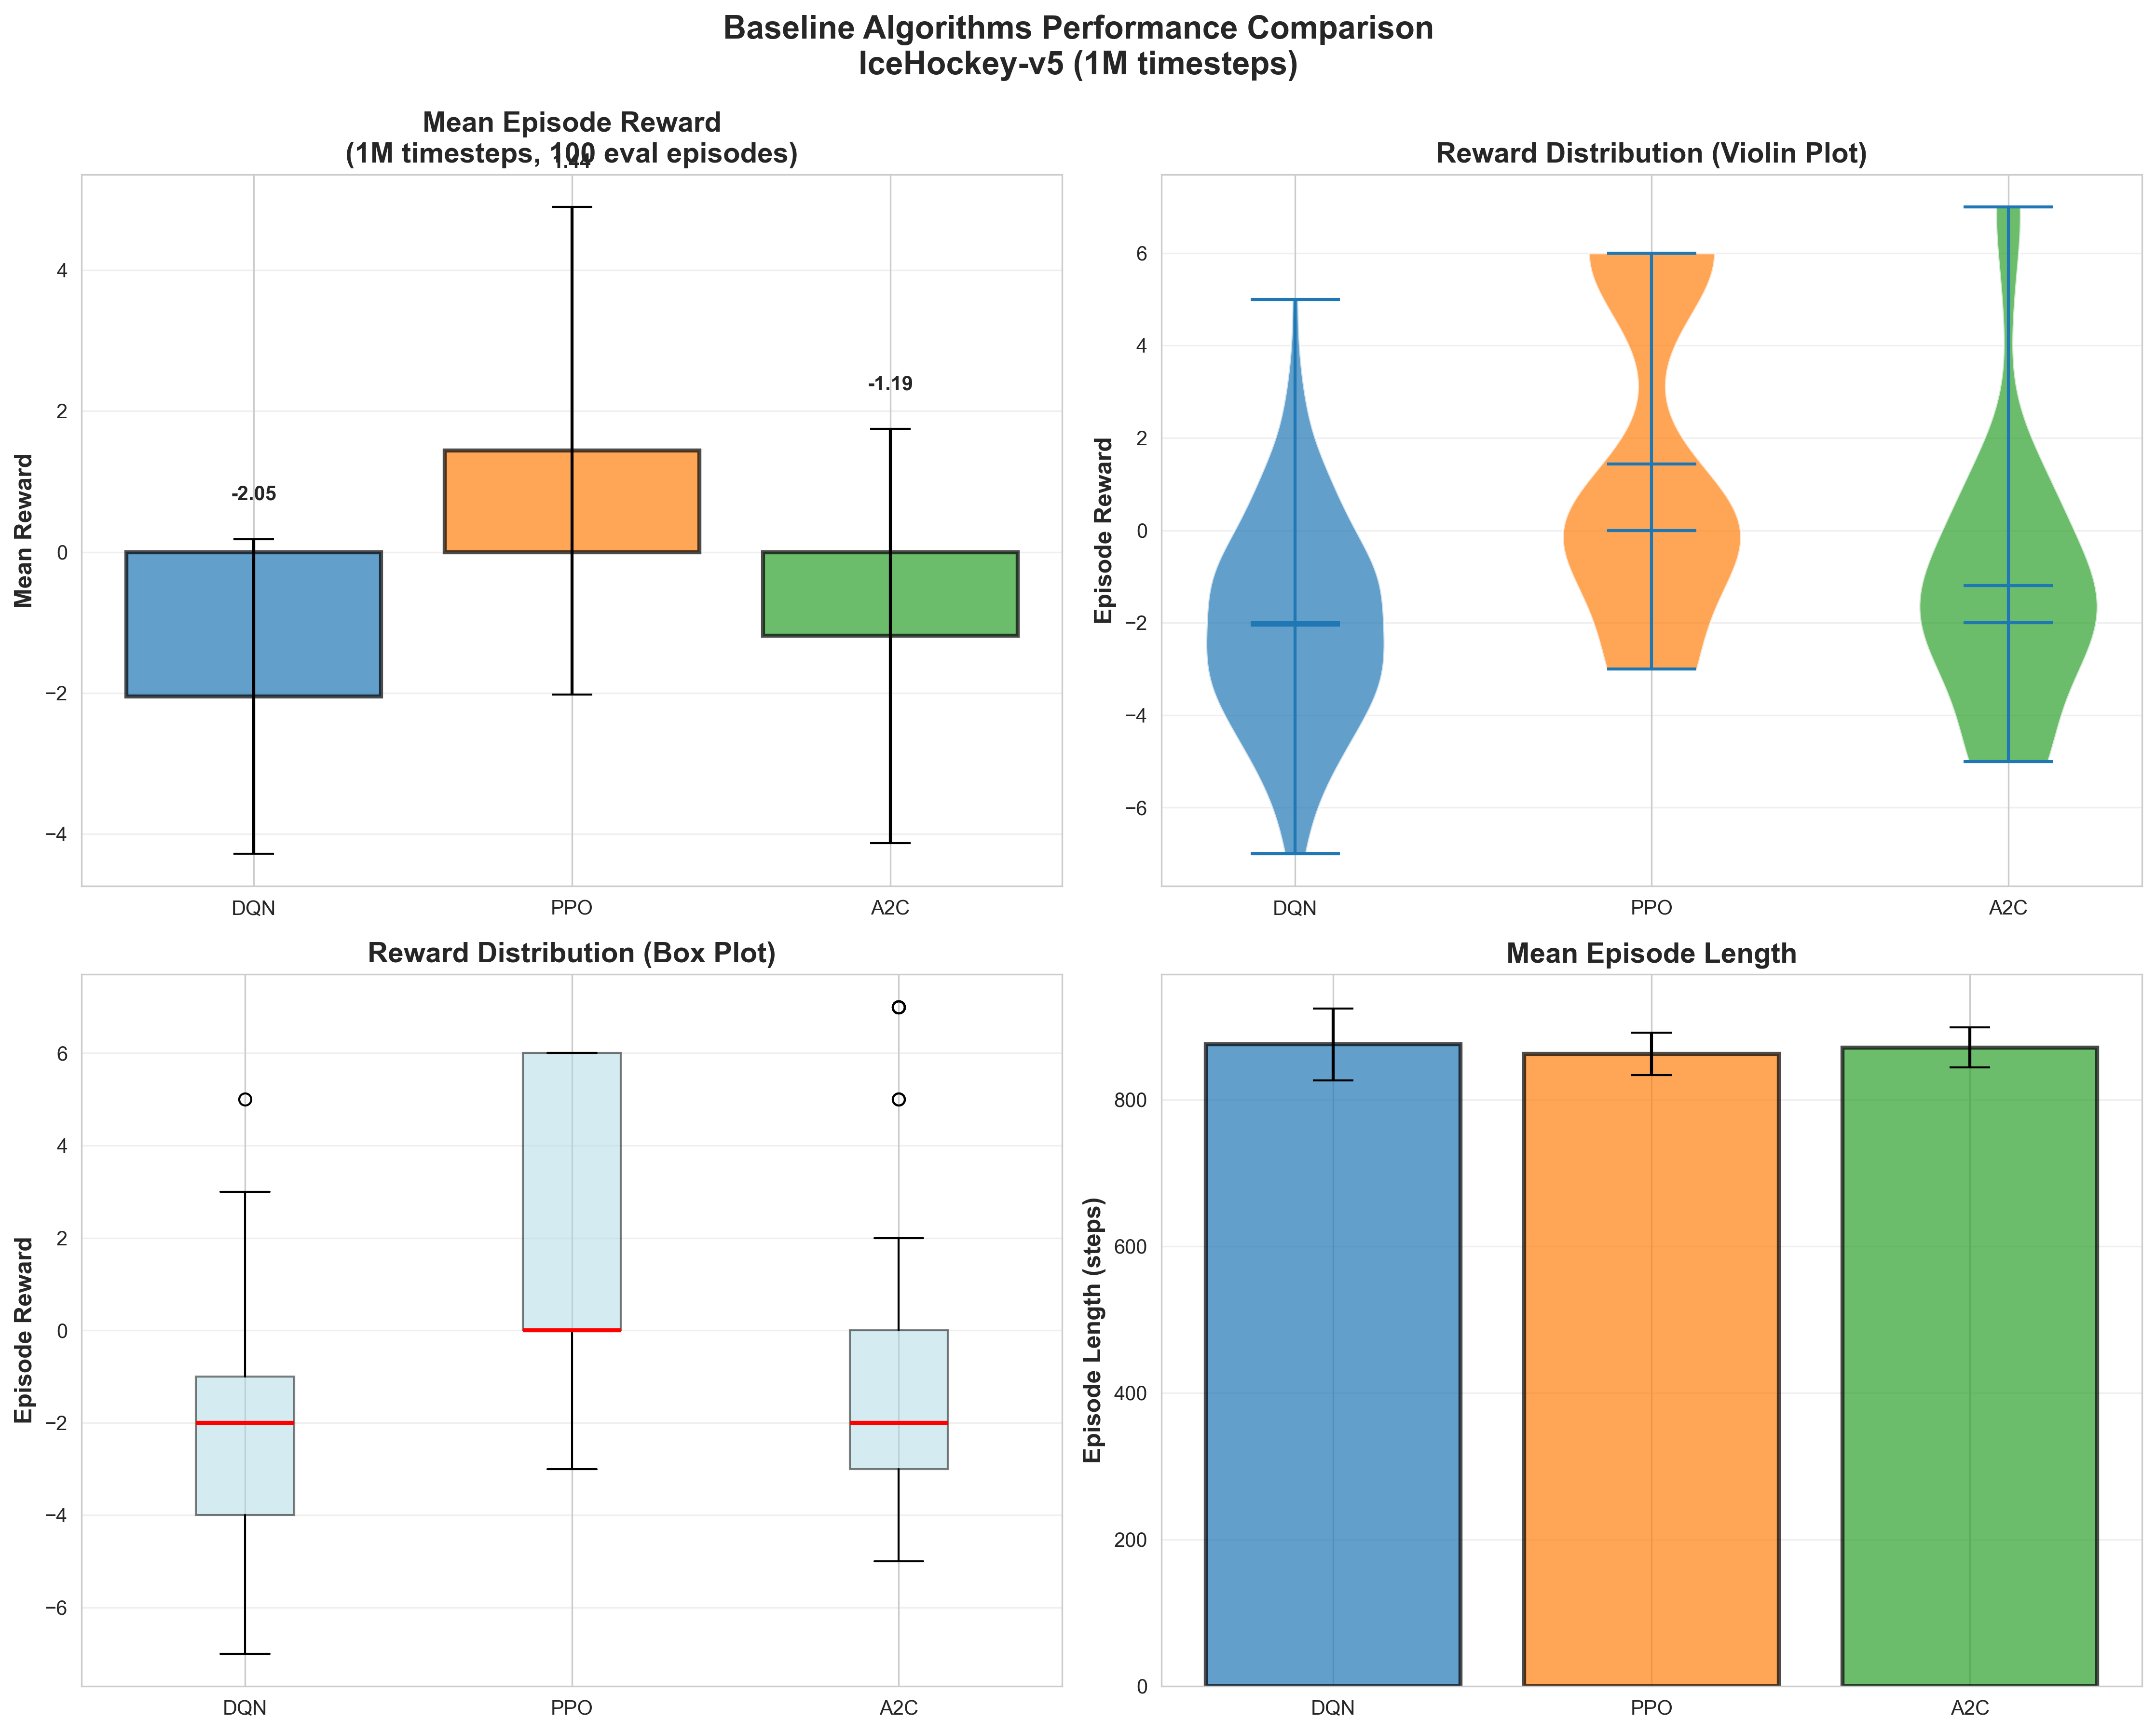


Reward Distributions:


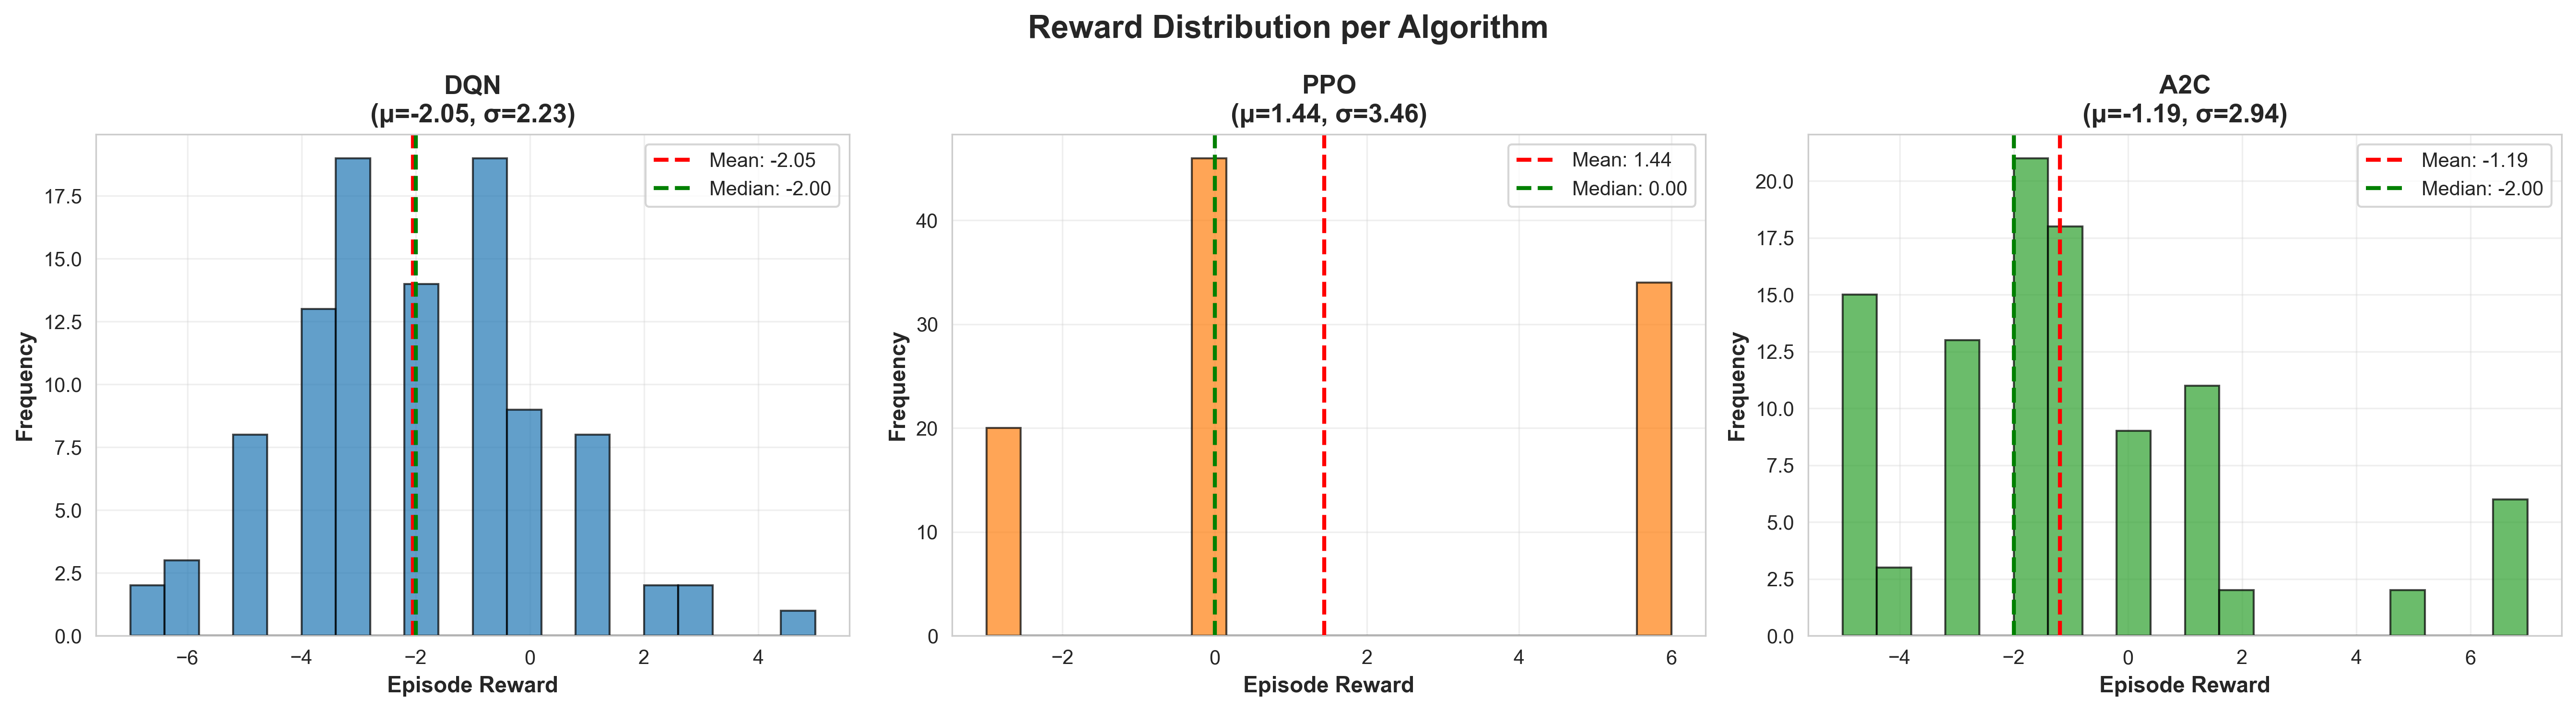


Learning Curves:


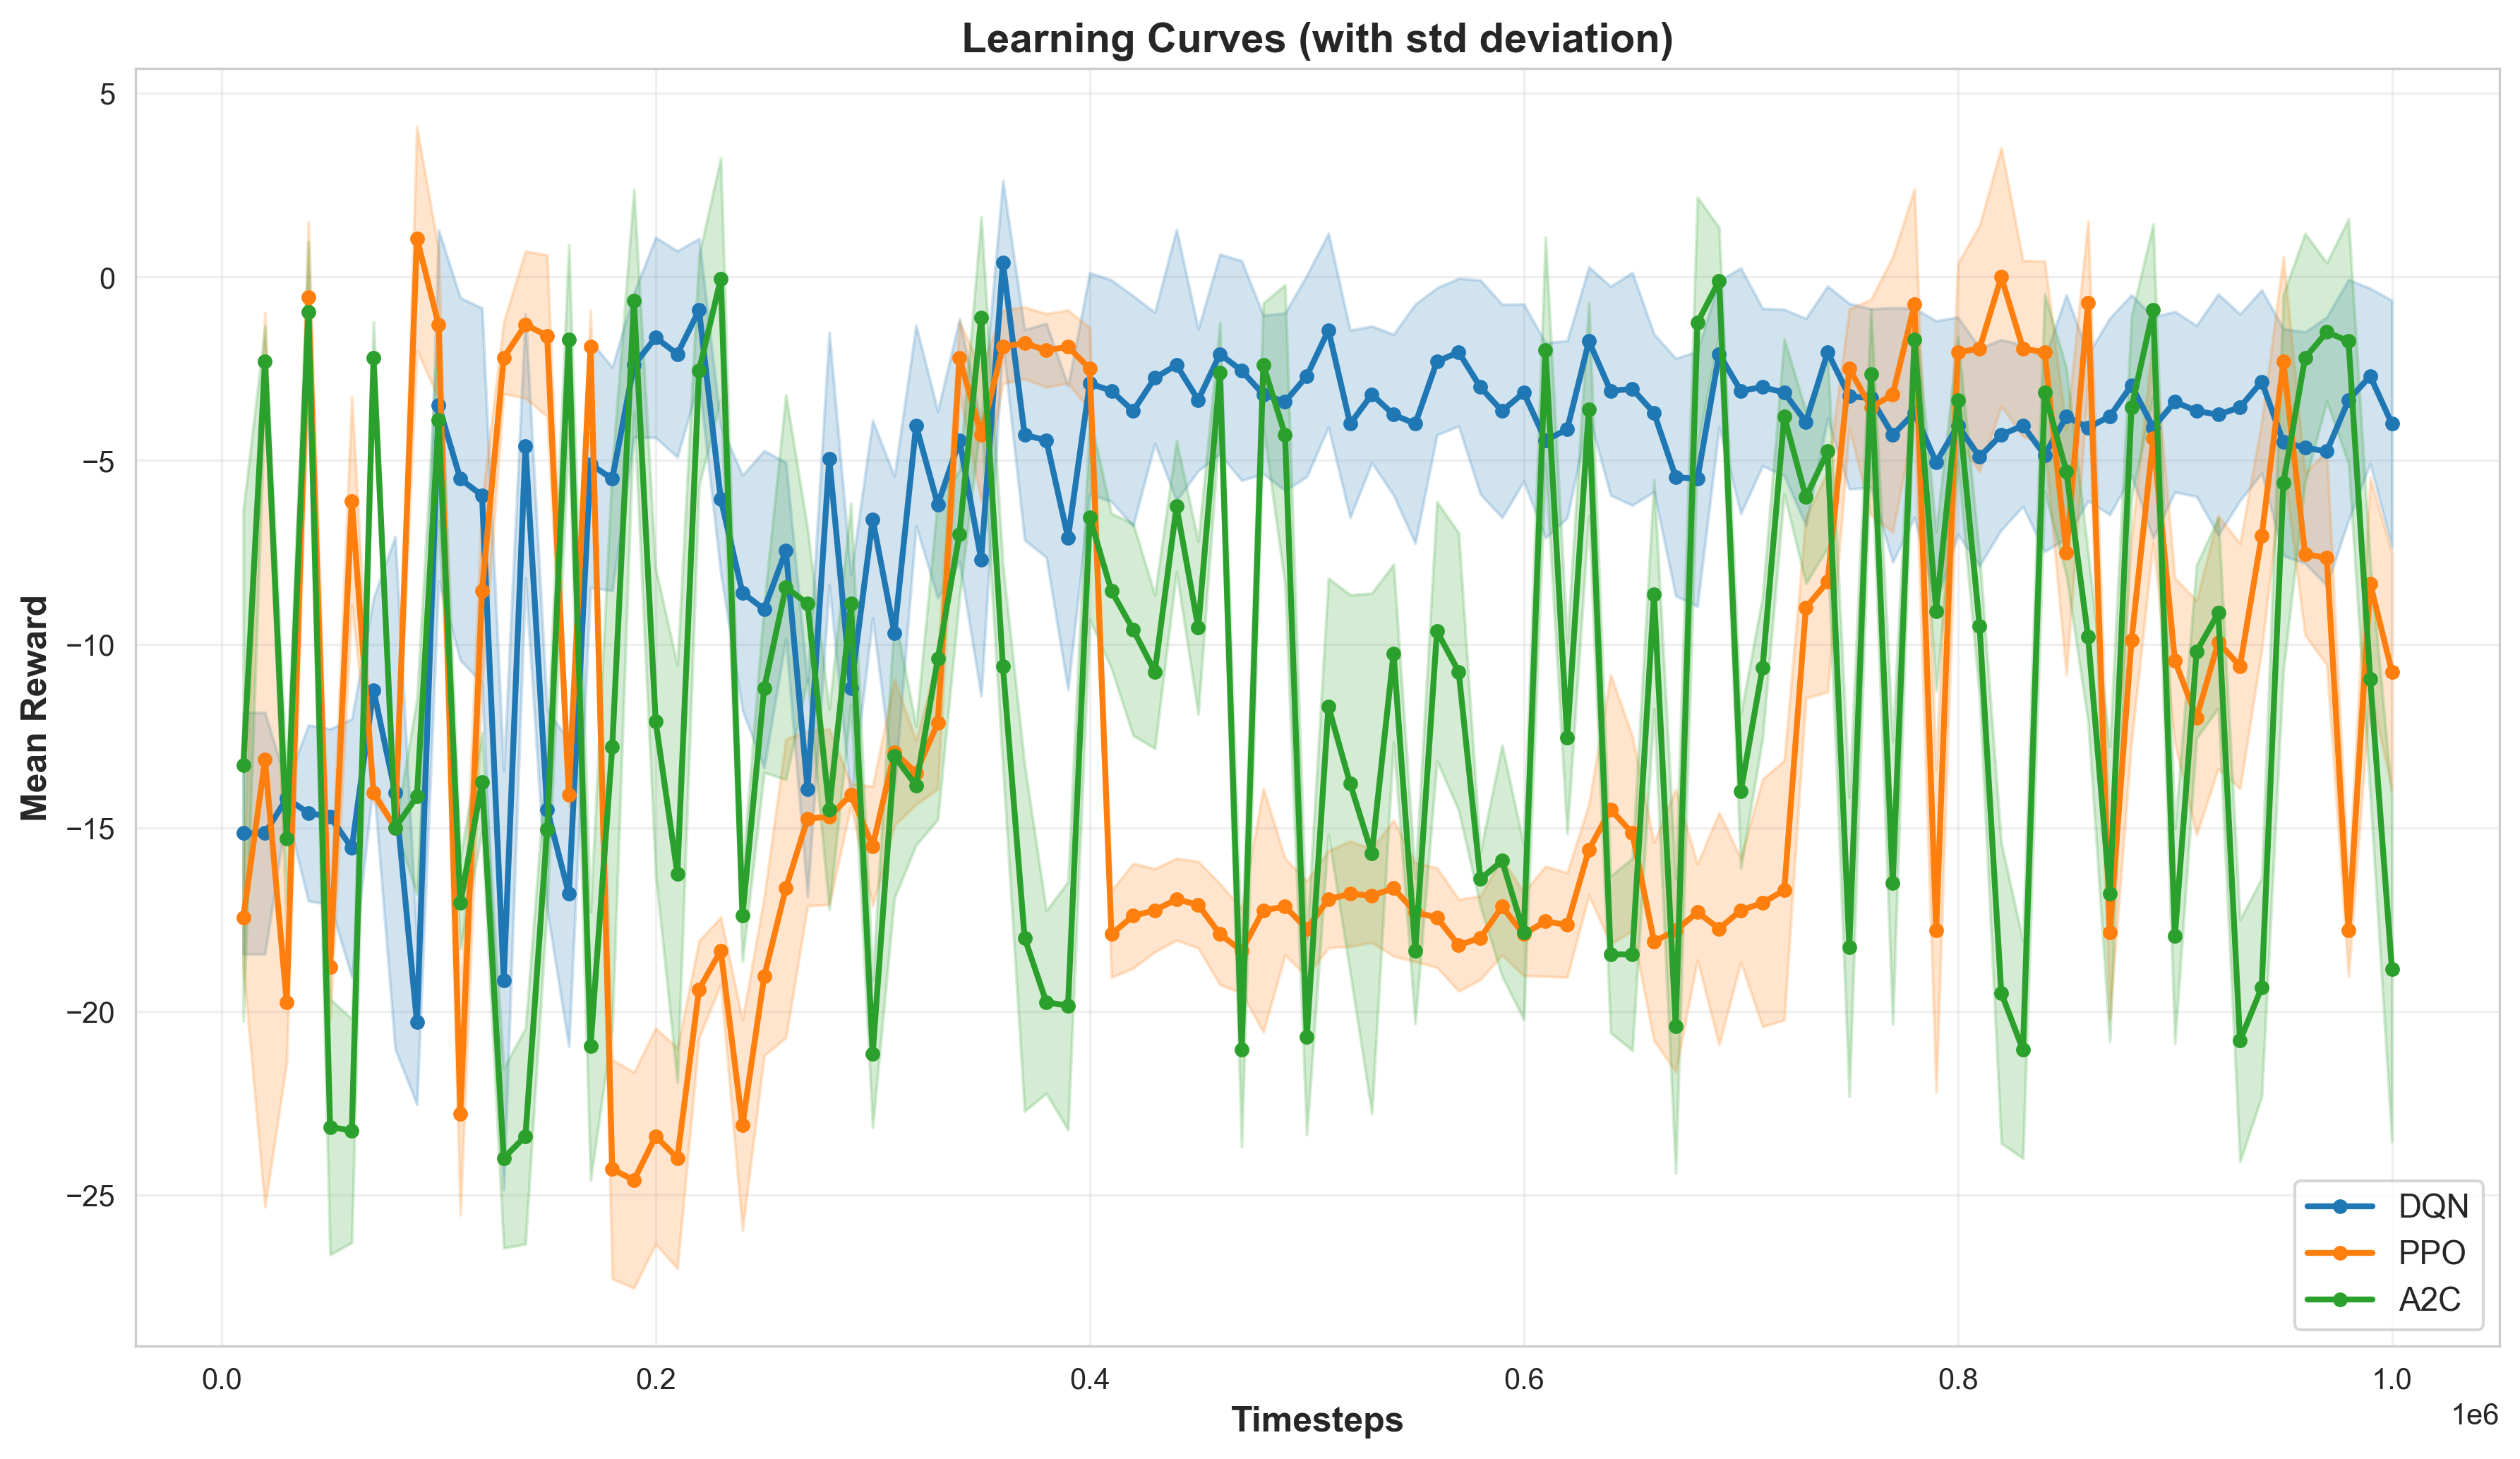

In [14]:
from IPython.display import Image, display

print("\nPerformance Comparison:")
display(Image('baseline_1M/figures/baseline_performance.png'))

print("\nReward Distributions:")
display(Image('baseline_1M/figures/baseline_distributions.png'))

print("\nLearning Curves:")
display(Image('baseline_1M/figures/baseline_learning_curves.png'))

***
## 5. Custom Environment Agent

In [41]:
"""
CUSTOM ENVIRONMENT TRAINING - 1M TIMESTEPS
Uses CustomIceHockeyEnv with reward engineering
"""

import gymnasium as gym
import numpy as np
import os
import time
import json
from typing import Dict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, CallbackList
from stable_baselines3.common.atari_wrappers import AtariWrapper

# Import your custom environment (assuming it's defined in previous cells)
# from your_notebook import CustomIceHockeyEnv, make_custom_icehockey_env


# ==========================================
# CONFIGURATION
# ==========================================

class CustomConfig:
    """Configuration for custom environment training"""
    
    # Environment
    ENV_ID = 'ALE/IceHockey-v5'
    N_STACK = 4
    
    # Training
    TOTAL_TIMESTEPS = 1_000_000  # 1M per algorithm
    EVAL_FREQ = 10_000
    N_EVAL_EPISODES = 20
    SAVE_FREQ = 50_000
    DEVICE = 'cuda'
    
    # Directories
    BASE_DIR = 'custom_1M/'
    MODELS_DIR = BASE_DIR + 'models/'
    LOGS_DIR = BASE_DIR + 'logs/'
    RESULTS_DIR = BASE_DIR + 'results/'
    FIGURES_DIR = BASE_DIR + 'figures/'
    
    # Custom reward parameters (from your CustomIceHockeyEnv)
    REWARD_PARAMS = {
        'goal_scored_reward': 1.0,
        'goal_conceded_penalty': -1.0,
        'movement_bonus': 0.001,
        'fire_bonus': 0.002,
        'repetition_penalty_base': -0.001,
        'repetition_threshold': 5,
        'fire_window_penalty': -0.01,
        'fire_window_size': 30,
    }
    
    # Same algorithms as baseline (for fair comparison)
    ALGORITHMS = {
        'DQN': {
            'class': DQN,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 1e-4,
                'buffer_size': 100_000,
                'learning_starts': 50_000,
                'batch_size': 32,
                'tau': 1.0,
                'gamma': 0.99,
                'train_freq': 4,
                'gradient_steps': 1,
                'target_update_interval': 10_000,
                'exploration_fraction': 0.1,
                'exploration_initial_eps': 1.0,
                'exploration_final_eps': 0.01,
                'verbose': 1,
            }
        },
        'PPO': {
            'class': PPO,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 2.5e-4,
                'n_steps': 128,
                'batch_size': 256,
                'n_epochs': 4,
                'gamma': 0.99,
                'gae_lambda': 0.95,
                'clip_range': 0.1,
                'clip_range_vf': None,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5,
                'verbose': 1,
            }
        },
        'A2C': {
            'class': A2C,
            'policy': 'CnnPolicy',
            'hyperparams': {
                'learning_rate': 7e-4,
                'n_steps': 5,
                'gamma': 0.99,
                'gae_lambda': 1.0,
                'ent_coef': 0.01,
                'vf_coef': 0.5,
                'max_grad_norm': 0.5,
                'rms_prop_eps': 1e-5,
                'verbose': 1,
            }
        }
    }
    
    @classmethod
    def create_dirs(cls):
        """Create all necessary directories"""
        dirs = [cls.BASE_DIR, cls.MODELS_DIR, cls.LOGS_DIR, 
                cls.RESULTS_DIR, cls.FIGURES_DIR]
        
        for dir_path in dirs:
            os.makedirs(dir_path, exist_ok=True)
        
        for algo in cls.ALGORITHMS.keys():
            os.makedirs(os.path.join(cls.MODELS_DIR, algo.lower()), exist_ok=True)
            os.makedirs(os.path.join(cls.LOGS_DIR, algo.lower()), exist_ok=True)
            os.makedirs(os.path.join(cls.RESULTS_DIR, algo.lower()), exist_ok=True)
        
        # Save reward parameters
        with open(os.path.join(cls.BASE_DIR, 'reward_parameters.json'), 'w') as f:
            json.dump(cls.REWARD_PARAMS, f, indent=2)

In [42]:
def make_custom_env():
    """Create single custom IceHockey environment"""
    env = gym.make(CustomConfig.ENV_ID)
    env = AtariWrapper(env)
    env = CustomRewardWrapper(
        env,
        **CustomConfig.REWARD_PARAMS
    )
    return env


def make_custom_vec_env():
    """Create vectorized + frame stacked custom environment"""
    env = DummyVecEnv([make_custom_env])
    env = VecFrameStack(env, n_stack=CustomConfig.N_STACK)
    return env

In [43]:
def train_custom_algorithm(algo_name: str, config: CustomConfig = CustomConfig) -> Dict:
    """
    Train a single algorithm on CUSTOM environment for 1M timesteps
    
    Args:
        algo_name: 'DQN', 'PPO', or 'A2C'
        config: Configuration object
    
    Returns:
        Dictionary with training results
    """
    print("\n" + "="*80)
    print(f"TRAINING {algo_name} ON CUSTOM ENVIRONMENT - 1,000,000 TIMESTEPS")
    print("="*80 + "\n")
    
    # Get algorithm configuration
    algo_config = config.ALGORITHMS[algo_name]
    AlgoClass = algo_config['class']
    
    print(f"Algorithm: {algo_name}")
    print(f"Environment: CUSTOM IceHockey (with reward engineering)")
    print(f"Total timesteps: {config.TOTAL_TIMESTEPS:,}")
    
    print(f"\nReward Engineering Parameters:")
    for key, value in config.REWARD_PARAMS.items():
        print(f"  {key:30s}: {value}")
    
    print(f"\nHyperparameters:")
    for key, value in algo_config['hyperparams'].items():
        print(f"  {key:25s}: {value}")
    
    # Create environments
    print("\nCreating custom environments...")
    train_env = make_custom_vec_env()
    eval_env = make_custom_vec_env()
    
    # Setup callbacks
    eval_callback = EvalCallback(
        eval_env=eval_env,
        best_model_save_path=os.path.join(config.MODELS_DIR, algo_name.lower()),
        log_path=os.path.join(config.LOGS_DIR, algo_name.lower()),
        eval_freq=config.EVAL_FREQ,
        n_eval_episodes=config.N_EVAL_EPISODES,
        deterministic=True,
        render=False,
        verbose=1
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=config.SAVE_FREQ,
        save_path=os.path.join(config.MODELS_DIR, algo_name.lower()),
        name_prefix=f'{algo_name.lower()}_custom_checkpoint',
        verbose=1
    )
    
    callback = CallbackList([eval_callback, checkpoint_callback])
    
    # Create model
    print(f"\nCreating {algo_name} model...")
    model = AlgoClass(
        policy=algo_config['policy'],
        env=train_env,
        tensorboard_log=os.path.join(config.LOGS_DIR, algo_name.lower()),
        device=config.DEVICE,
        **algo_config['hyperparams']
    )
    
    # Train
    print(f"\n{'='*80}")
    print(f"STARTING TRAINING")
    print(f"{'='*80}\n")
    print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nProgress will be saved every {config.SAVE_FREQ:,} steps")
    
    start_time = time.time()
    
    try:
        model.learn(
            total_timesteps=config.TOTAL_TIMESTEPS,
            callback=callback,
            progress_bar=True,
            log_interval=10
        )
        
        completed = True
        
    except KeyboardInterrupt:
        print("\n\nTRAINING INTERRUPTED BY USER")
        print("Progress has been saved.")
        completed = False
    
    except Exception as e:
        print(f"\n\nERROR DURING TRAINING: {e}")
        import traceback
        traceback.print_exc()
        completed = False
    
    end_time = time.time()
    training_time = end_time - start_time
    
    # Save final model
    final_model_path = os.path.join(
        config.MODELS_DIR,
        algo_name.lower(),
        f'{algo_name.lower()}_custom_final_1M.zip'
    )
    model.save(final_model_path)
    
    # Compile results
    results = {
        'algorithm': algo_name,
        'environment': 'custom',
        'completed': completed,
        'total_timesteps': config.TOTAL_TIMESTEPS,
        'training_time_seconds': training_time,
        'training_time_hours': training_time / 3600,
        'timesteps_per_second': config.TOTAL_TIMESTEPS / training_time,
        'reward_params': config.REWARD_PARAMS,
        'final_model_path': final_model_path,
        'best_model_path': os.path.join(config.MODELS_DIR, algo_name.lower(), 'best_model.zip'),
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    }
    
    # Save training info
    with open(os.path.join(config.RESULTS_DIR, algo_name.lower(), 'training_info.json'), 'w') as f:
        json.dump(results, f, indent=2)
    
    # Print summary
    print(f"\n{'='*80}")
    print(f"TRAINING {'COMPLETE' if completed else 'STOPPED'}")
    print(f"{'='*80}\n")
    print(f"Algorithm: {algo_name}")
    print(f"Environment: Custom (with reward engineering)")
    print(f"Timesteps: {config.TOTAL_TIMESTEPS:,}")
    print(f"Training time: {training_time/3600:.2f} hours ({training_time:.0f} seconds)")
    print(f"Speed: {results['timesteps_per_second']:.2f} timesteps/second")
    print(f"Final model saved: {final_model_path}")
    print(f"Best model saved: {results['best_model_path']}")
    
    train_env.close()
    eval_env.close()
    
    return results


def train_all_custom_algorithms(config: CustomConfig = CustomConfig) -> Dict[str, Dict]:
    """
    Train all algorithms on custom environment
    
    Returns:
        Dictionary with results for each algorithm
    """
    config.create_dirs()
    
    print("CUSTOM ENVIRONMENT TRAINING - ALL ALGORITHMS (1M TIMESTEPS EACH)")
    print("\n")
    
    print("Configuration:")
    print(f"  Base Environment: {config.ENV_ID}")
    print(f"  Custom Rewards: ENABLED")
    print(f"  Timesteps per algorithm: {config.TOTAL_TIMESTEPS:,}")
    print(f"  Algorithms: {list(config.ALGORITHMS.keys())}")
    print(f"  Frame stack: {config.N_STACK}")
    print(f"  Device: {config.DEVICE}")
    
    print(f"\nReward Engineering:")
    for key, value in config.REWARD_PARAMS.items():
        print(f"  {key}: {value}")
    
    print(f"\nResults saved to: {config.BASE_DIR}")
    print("\n" + "="*80)
    
    input("\nPress Enter to start training (or Ctrl+C to cancel)...")
    
    all_results = {}
    training_order = list(config.ALGORITHMS.keys())
    
    for i, algo_name in enumerate(training_order, 1):
        print(f"\n\n{'='*80}")
        print(f"ALGORITHM {i}/{len(training_order)}: {algo_name}")
        print(f"{'='*80}\n")
        
        try:
            results = train_custom_algorithm(algo_name, config)
            all_results[algo_name] = results
            
            print(f"\n{algo_name} training complete!")
            
            # Show progress
            completed = sum(1 for r in all_results.values() if r['completed'])
            print(f"\nProgress: {completed}/{len(training_order)} algorithms completed")
            
            if i < len(training_order):
                print(f"\nNext: {training_order[i]}")
                time.sleep(2)
                
        except KeyboardInterrupt:
            print(f"\n\nTraining suite interrupted!")
            print(f"Completed algorithms: {list(all_results.keys())}")
            break
        
        except Exception as e:
            print(f"\nError training {algo_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    # Final summary
    print("\n\n" + "="*80)
    print("CUSTOM TRAINING SUITE COMPLETE")
    print("="*80 + "\n")
    
    print("Results summary:")
    for algo_name, results in all_results.items():
        status = "COMPLETE" if results['completed'] else "INCOMPLETE"
        print(f"\n{algo_name}: {status}")
        print(f"  Training time: {results['training_time_hours']:.2f} hours")
        print(f"  Speed: {results['timesteps_per_second']:.2f} timesteps/sec")
        print(f"  Model: {results['best_model_path']}")
    
    # Save summary
    summary_path = os.path.join(config.RESULTS_DIR, 'training_summary.json')
    with open(summary_path, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nSummary saved to: {summary_path}")
    
    print("\n" + "="*80)
    print("Next steps:")
    print("  1. Evaluate custom models: evaluate_all_custom()")
    print("  2. Compare with baseline (Section 6)")
    print("="*80 + "\n")
    
    return all_results


In [44]:
def evaluate_custom_model(algo_name: str, n_episodes: int = 100, 
                         config: CustomConfig = CustomConfig) -> Dict:
    """
    Evaluate a trained custom environment model
    
    Args:
        algo_name: Algorithm name
        n_episodes: Number of evaluation episodes
        config: Configuration object
    
    Returns:
        Evaluation results dictionary with custom stats
    """
    print(f"\n{'='*80}")
    print(f"EVALUATING {algo_name} ON CUSTOM ENV (n={n_episodes} episodes)")
    print(f"{'='*80}\n")
    
    # Load model
    model_path = os.path.join(config.MODELS_DIR, algo_name.lower(), 'best_model.zip')
    
    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        return None
    
    AlgoClass = config.ALGORITHMS[algo_name]['class']
    print(f"Loading model from: {model_path}")
    model = AlgoClass.load(model_path)
    
    # Create eval environment
    eval_env = make_custom_vec_env()
    
    # Evaluate
    print(f"Running {n_episodes} evaluation episodes...")
    start_time = time.time()
    
    episode_rewards = []
    episode_lengths = []
    episode_original_rewards = []
    episode_modified_rewards = []
    
    # Custom stats
    goals_scored_list = []
    goals_conceded_list = []
    movement_bonuses_list = []
    fire_bonuses_list = []
    repetition_penalties_list = []
    fire_window_penalties_list = []
    
    for ep in range(n_episodes):
        obs = eval_env.reset()
        done = False
        episode_length = 0
        
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, info = eval_env.step(action)
            episode_length += 1
        
        # Extract custom stats from final info
        if len(info) > 0 and 'episode_stats' in info[0]:
            stats = info[0]['episode_stats']
            episode_original_rewards.append(stats['total_original_reward'])
            episode_modified_rewards.append(stats['total_modified_reward'])
            goals_scored_list.append(stats['goals_scored'])
            goals_conceded_list.append(stats['goals_conceded'])
            movement_bonuses_list.append(stats['movement_bonuses'])
            fire_bonuses_list.append(stats['fire_bonuses'])
            repetition_penalties_list.append(stats['repetition_penalties'])
            fire_window_penalties_list.append(stats['fire_window_penalties'])
        
        episode_rewards.append(reward[0])
        episode_lengths.append(episode_length)
        
        if (ep + 1) % 20 == 0:
            print(f"  Progress: {ep + 1}/{n_episodes} episodes...")
    
    eval_time = time.time() - start_time
    eval_env.close()
    
    # Compile results
    results = {
        'algorithm': algo_name,
        'environment': 'custom',
        'n_episodes': n_episodes,
        'mean_reward': float(np.mean(episode_rewards)),
        'std_reward': float(np.std(episode_rewards)),
        'min_reward': float(np.min(episode_rewards)),
        'max_reward': float(np.max(episode_rewards)),
        'median_reward': float(np.median(episode_rewards)),
        'q25_reward': float(np.percentile(episode_rewards, 25)),
        'q75_reward': float(np.percentile(episode_rewards, 75)),
        'mean_length': float(np.mean(episode_lengths)),
        'std_length': float(np.std(episode_lengths)),
        'eval_time_seconds': eval_time,
        
        # Custom environment specific stats
        'custom_stats': {
            'mean_original_reward': float(np.mean(episode_original_rewards)) if episode_original_rewards else None,
            'mean_modified_reward': float(np.mean(episode_modified_rewards)) if episode_modified_rewards else None,
            'reward_delta': float(np.mean(episode_modified_rewards) - np.mean(episode_original_rewards)) if episode_modified_rewards else None,
            'mean_goals_scored': float(np.mean(goals_scored_list)) if goals_scored_list else None,
            'mean_goals_conceded': float(np.mean(goals_conceded_list)) if goals_conceded_list else None,
            'mean_movement_bonuses': float(np.mean(movement_bonuses_list)) if movement_bonuses_list else None,
            'mean_fire_bonuses': float(np.mean(fire_bonuses_list)) if fire_bonuses_list else None,
            'mean_repetition_penalties': float(np.mean(repetition_penalties_list)) if repetition_penalties_list else None,
            'mean_fire_window_penalties': float(np.mean(fire_window_penalties_list)) if fire_window_penalties_list else None,
        }
    }
    
    # Print results
    print(f"\nRESULTS:")
    print(f"  Mean Reward:   {results['mean_reward']:8.3f} ± {results['std_reward']:.3f}")
    print(f"  Median Reward: {results['median_reward']:8.3f}")
    print(f"  Min/Max:       [{results['min_reward']:6.1f}, {results['max_reward']:6.1f}]")
    print(f"  Mean Length:   {results['mean_length']:8.1f} ± {results['std_length']:.1f} steps")
    
    if results['custom_stats']['mean_original_reward'] is not None:
        print(f"\nCUSTOM ENVIRONMENT STATS:")
        print(f"  Original Reward:      {results['custom_stats']['mean_original_reward']:8.3f}")
        print(f"  Modified Reward:      {results['custom_stats']['mean_modified_reward']:8.3f}")
        print(f"  Reward Delta:         {results['custom_stats']['reward_delta']:+8.3f}")
        print(f"  Goals Scored:         {results['custom_stats']['mean_goals_scored']:8.2f}")
        print(f"  Goals Conceded:       {results['custom_stats']['mean_goals_conceded']:8.2f}")
        print(f"  Movement Bonuses:     {results['custom_stats']['mean_movement_bonuses']:8.1f}")
        print(f"  Fire Bonuses:         {results['custom_stats']['mean_fire_bonuses']:8.1f}")
        print(f"  Repetition Penalties: {results['custom_stats']['mean_repetition_penalties']:8.1f}")
        print(f"  Fire Window Penalties:{results['custom_stats']['mean_fire_window_penalties']:8.1f}")
    
    print(f"  Eval time:            {eval_time:8.2f} seconds")
    
    # Save results
    results_path = os.path.join(config.RESULTS_DIR, algo_name.lower(), 'evaluation_results.json')
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=2)
    
    # Save detailed data
    np.save(
        os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_rewards.npy'),
        episode_rewards
    )
    np.save(
        os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_lengths.npy'),
        episode_lengths
    )
    
    if episode_original_rewards:
        np.save(
            os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_original_rewards.npy'),
            episode_original_rewards
        )
        np.save(
            os.path.join(config.RESULTS_DIR, algo_name.lower(), 'episode_modified_rewards.npy'),
            episode_modified_rewards
        )
    
    print(f"\nResults saved to: {config.RESULTS_DIR}{algo_name.lower()}/")
    
    return results


def evaluate_all_custom(n_episodes: int = 100, config: CustomConfig = CustomConfig) -> Dict[str, Dict]:
    """
    Evaluate all trained custom models
    
    Returns:
        Dictionary with evaluation results for each algorithm
    """
    print("CUSTOM ENVIRONMENT EVALUATION - ALL ALGORITHMS")
    
    all_results = {}
    
    for algo_name in config.ALGORITHMS.keys():
        try:
            results = evaluate_custom_model(algo_name, n_episodes, config)
            if results:
                all_results[algo_name] = results
        except Exception as e:
            print(f"\nError evaluating {algo_name}: {e}")
            import traceback
            traceback.print_exc()
    
    if not all_results:
        print("\nNo results to compare")
        return {}
    
    # Print comparison
    print("\n" + "="*80)
    print("CUSTOM ENVIRONMENT COMPARISON TABLE")
    print("="*80 + "\n")
    
    # Create comparison DataFrame
    comparison_data = []
    for algo, res in all_results.items():
        row = {
            'Algorithm': algo,
            'Mean Reward': f"{res['mean_reward']:.3f}",
            'Std': f"{res['std_reward']:.3f}",
            'Median': f"{res['median_reward']:.3f}",
        }
        
        if res['custom_stats']['mean_goals_scored']:
            row['Goals Scored'] = f"{res['custom_stats']['mean_goals_scored']:.2f}"
            row['Goals Conceded'] = f"{res['custom_stats']['mean_goals_conceded']:.2f}"
            row['Reward Delta'] = f"{res['custom_stats']['reward_delta']:+.3f}"
        
        comparison_data.append(row)
    
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))
    
    # Identify best
    best_algo = max(all_results.items(), key=lambda x: x[1]['mean_reward'])
    print(f"\nBEST ON CUSTOM ENVIRONMENT: {best_algo[0]}")
    print(f"   Mean Reward: {best_algo[1]['mean_reward']:.3f} ± {best_algo[1]['std_reward']:.3f}")
    
    # Save comparison
    df.to_csv(os.path.join(config.RESULTS_DIR, 'custom_comparison.csv'), index=False)
    
    with open(os.path.join(config.RESULTS_DIR, 'evaluation_summary.json'), 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\nComparison saved to: {config.RESULTS_DIR}")
    
    return all_results

In [45]:
def create_custom_visualizations(config: CustomConfig = CustomConfig):
    """Generate comprehensive visualizations of custom environment results"""
    
    print("\nGENERATING CUSTOM ENVIRONMENT VISUALIZATIONS\n")
    
    # Load evaluation results
    results = {}
    for algo_name in config.ALGORITHMS.keys():
        results_path = os.path.join(
            config.RESULTS_DIR,
            algo_name.lower(),
            'evaluation_results.json'
        )
        
        if os.path.exists(results_path):
            with open(results_path, 'r') as f:
                results[algo_name] = json.load(f)
            
            # Load episode rewards
            rewards_path = os.path.join(
                config.RESULTS_DIR,
                algo_name.lower(),
                'episode_rewards.npy'
            )
            if os.path.exists(rewards_path):
                results[algo_name]['episode_rewards'] = np.load(rewards_path)
    
    if not results:
        print("No results found to visualize")
        return
    
    sns.set_style("whitegrid")
    algorithms = list(results.keys())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # ==========================================
    # Figure 1: Performance Comparison
    # ==========================================
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1.1: Bar chart - Mean rewards
    means = [results[algo]['mean_reward'] for algo in algorithms]
    stds = [results[algo]['std_reward'] for algo in algorithms]
    
    axes[0, 0].bar(algorithms, means, yerr=stds, capsize=10,
                   color=colors[:len(algorithms)], alpha=0.7, edgecolor='black', linewidth=2)
    axes[0, 0].set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Mean Episode Reward\n(1M timesteps, 100 eval episodes)', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, (mean, std) in enumerate(zip(means, stds)):
        axes[0, 0].text(i, mean + std + 0.5, f'{mean:.2f}',
                       ha='center', va='bottom', fontweight='bold')
    
    # 1.2: Violin plot
    violin_data = [results[algo]['episode_rewards'] for algo in algorithms]
    parts = axes[0, 1].violinplot(violin_data, positions=range(len(algorithms)),
                                   showmeans=True, showmedians=True)
    
    for i, pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(0.7)
    
    axes[0, 1].set_xticks(range(len(algorithms)))
    axes[0, 1].set_xticklabels(algorithms)
    axes[0, 1].set_ylabel('Episode Reward', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Reward Distribution (Violin Plot)', fontsize=14, fontweight='bold')
    axes[0, 1].grid(alpha=0.3, axis='y')
    
    # 1.3: Box plot
    axes[1, 0].boxplot(violin_data, labels=algorithms, patch_artist=True,
                       boxprops=dict(facecolor='lightblue', alpha=0.5),
                       medianprops=dict(color='red', linewidth=2))
    axes[1, 0].set_ylabel('Episode Reward', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Reward Distribution (Box Plot)', fontsize=14, fontweight='bold')
    axes[1, 0].grid(alpha=0.3, axis='y')
    
    # 1.4: Episode lengths
    lengths = [results[algo]['mean_length'] for algo in algorithms]
    length_stds = [results[algo]['std_length'] for algo in algorithms]
    
    axes[1, 1].bar(algorithms, lengths, yerr=length_stds, capsize=10,
                   color=colors[:len(algorithms)], alpha=0.7, edgecolor='black', linewidth=2)
    axes[1, 1].set_ylabel('Episode Length (steps)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Mean Episode Length', fontsize=14, fontweight='bold')
    axes[1, 1].grid(alpha=0.3, axis='y')
    
    plt.suptitle('Custom Environment - Algorithms Performance Comparison\nIceHockey-v5 (1M timesteps)', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(config.FIGURES_DIR, 'custom_performance.png'), 
                dpi=300, bbox_inches='tight')
    print("Saved: custom_performance.png")
    plt.close()
    
    # ==========================================
    # Figure 2: Detailed distributions 
    # ==========================================
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, algo in enumerate(algorithms):
        axes[i].hist(results[algo]['episode_rewards'], bins=20, 
                    color=colors[i], alpha=0.7, edgecolor='black')
        axes[i].axvline(results[algo]['mean_reward'], color='red', 
                       linestyle='--', linewidth=2, label=f"Mean: {results[algo]['mean_reward']:.2f}")
        axes[i].axvline(results[algo]['median_reward'], color='green',
                       linestyle='--', linewidth=2, label=f"Median: {results[algo]['median_reward']:.2f}")
        axes[i].set_xlabel('Episode Reward', fontsize=11, fontweight='bold')
        axes[i].set_ylabel('Frequency', fontsize=11, fontweight='bold')
        axes[i].set_title(f'{algo}\n(μ={results[algo]["mean_reward"]:.2f}, σ={results[algo]["std_reward"]:.2f})',
                         fontsize=13, fontweight='bold')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.suptitle('Reward Distribution per Algorithm', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(config.FIGURES_DIR, 'custom_distributions.png'),
                dpi=300, bbox_inches='tight')
    print("Saved: custom_distributions.png")
    plt.close()
    
    # ==========================================
    # Figure 3: Learning curves 
    # ==========================================
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    
    found_curves = False
    for i, algo in enumerate(algorithms):
        # Try to load from evaluation callback
        eval_log_path = os.path.join(
            config.LOGS_DIR,
            algo.lower(),
            'evaluations.npz'
        )
        
        if os.path.exists(eval_log_path):
            data = np.load(eval_log_path)
            timesteps = data['timesteps']
            results_array = data['results']
            mean_rewards = np.mean(results_array, axis=1)
            std_rewards = np.std(results_array, axis=1)
            
            ax.plot(timesteps, mean_rewards, label=algo, color=colors[i], 
                   linewidth=2, marker='o', markersize=4)
            ax.fill_between(timesteps, 
                           mean_rewards - std_rewards,
                           mean_rewards + std_rewards,
                           alpha=0.2, color=colors[i])
            found_curves = True
    
    if found_curves:
        ax.set_xlabel('Timesteps', fontsize=12, fontweight='bold')
        ax.set_ylabel('Mean Reward', fontsize=12, fontweight='bold')
        ax.set_title('Learning Curves (with std deviation)',
                    fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(os.path.join(config.FIGURES_DIR, 'custom_learning_curves.png'),
                    dpi=300, bbox_inches='tight')
        print("Saved: custom_learning_curves.png")
    else:
        print("Learning curves not available")
    
    plt.close()
    
    print(f"\nAll visualizations saved to: {config.FIGURES_DIR}")

### 5.1 Training with custom rewards

In [ ]:
custom_training_results = train_all_custom_algorithms(CustomConfig)
custom_training_results

### 5.3 Results per configuration

In [47]:
custom_eval_summary = evaluate_all_custom(n_episodes=100, config=CustomConfig)
custom_eval_summary

CUSTOM ENVIRONMENT EVALUATION - ALL ALGORITHMS

EVALUATING DQN ON CUSTOM ENV (n=100 episodes)

Loading model from: custom_1M/models/dqn\best_model.zip
Running 100 evaluation episodes...
  Progress: 20/100 episodes...
  Progress: 40/100 episodes...
  Progress: 60/100 episodes...
  Progress: 80/100 episodes...
  Progress: 100/100 episodes...

RESULTS:
  Mean Reward:      0.001 ± 0.002
  Median Reward:    0.001
  Min/Max:       [  -0.0,    0.0]
  Mean Length:      830.9 ± 45.4 steps

CUSTOM ENVIRONMENT STATS:
  Original Reward:        -4.410
  Modified Reward:        -3.634
  Reward Delta:           +0.776
  Goals Scored:             5.78
  Goals Conceded:          10.19
  Movement Bonuses:        216.8
  Fire Bonuses:            489.6
  Repetition Penalties:    100.5
  Fire Window Penalties:     0.3
  Eval time:              342.10 seconds

Results saved to: custom_1M/results/dqn/

EVALUATING PPO ON CUSTOM ENV (n=100 episodes)

Loading model from: custom_1M/models/ppo\best_model.zip
Runn

{'DQN': {'algorithm': 'DQN',
  'environment': 'custom',
  'n_episodes': 100,
  'mean_reward': 0.0007500001229345798,
  'std_reward': 0.0015580437611788511,
  'min_reward': -0.00800000037997961,
  'max_reward': 0.0020000000949949026,
  'median_reward': 0.0010000000474974513,
  'q25_reward': 0.0,
  'q75_reward': 0.0020000000949949026,
  'mean_length': 830.89,
  'std_length': 45.37441900454484,
  'eval_time_seconds': 342.10032320022583,
  'custom_stats': {'mean_original_reward': -4.41,
   'mean_modified_reward': -3.634020000000033,
   'reward_delta': 0.7759799999999673,
   'mean_goals_scored': 5.78,
   'mean_goals_conceded': 10.19,
   'mean_movement_bonuses': 216.83,
   'mean_fire_bonuses': 489.57,
   'mean_repetition_penalties': 100.45,
   'mean_fire_window_penalties': 0.34}},
 'PPO': {'algorithm': 'PPO',
  'environment': 'custom',
  'n_episodes': 100,
  'mean_reward': -0.018789999186992645,
  'std_reward': 0.02650105580687523,
  'min_reward': -0.10700000077486038,
  'max_reward': 0.0020

### 5.4 Best model selection

In [48]:
create_custom_visualizations(CustomConfig)


GENERATING CUSTOM ENVIRONMENT VISUALIZATIONS



C:\Users\simao\AppData\Local\Temp\ipykernel_8556\2500607824.py:73: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(violin_data, labels=algorithms, patch_artist=True,
C:\Users\simao\AppData\Local\Temp\ipykernel_8556\2500607824.py:92: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved: custom_performance.png
Saved: custom_distributions.png
Saved: custom_learning_curves.png

All visualizations saved to: custom_1M/figures/


In [49]:
from IPython.display import Image, display

print("\nCustom Environment Performance:")
display(Image('custom_1M/figures/custom_performance.png'))


Custom Environment Performance:


***
## 6. Evaluation and Comparison

### 6.1 Methodology

### 6.2 Quant results

### 6.3 Qual results

### 6.4 Learning curve analysis

### 6.5 Visualizations

***
## 7. Discussion

***
## 8. Conclusion

***
## 9. References

[1] Song, Y. et al. (2023). The Role of a Reward in Shaping Multiple Football Agents’ Behavior. <br>
[2] Zhang, H. et al. (2023). Embedding Contextual Information through Reward Shaping in Multi-Agent Learning. <br>
[3] Martins, F. B. et al. (2021). rSoccer: A Framework for Studying Reinforcement Learning. <br>
[4] Song, Y. et al. (2024). Boosting Studies of Multi-Agent RL on Google Research Football.